In [23]:
%pylab inline
%load_ext blackcellmagic
from collections import OrderedDict
import os
import glob
import pandas as pd
import seaborn as sns
import pandas as pd
import seaborn as sns
from riboraptor.plot_talk_theme import load_pub_theme
from riboraptor.plotting import plot_framewise_counts, setup_axis
from riboraptor.peak_finder_utils import *
from riboraptor.helpers import *
from riboraptor.ribotricer_utils import counts_to_tpm, count_matrix_to_tpm
from qvalue import estimate as qvalue
from scipy import signal
import six
from scipy.signal import savgol_filter
from statsmodels.stats.multitest import multipletests

load_pub_theme()
__FRAME_COLORS__ = ["#fc8d62", "#66c2a5", "#8da0cb"]

import proplot as plot
plot.rc.fontname = 'Arial'
plot.rc.large = 20
plot.rc.small = 16
plot.rc.ticklen = 10
plot.rc.tickratio = 0.5
plot.rc.linewidth = 2

def calculate_peaks(data, order=3, snr=2.5):
    """ Calculate Peaks
    """
    if isinstance(data, pd.Series):
        index = data.index
    else:
        index = np.arange(0, len(data))
    data = np.array(data)
    data_rel_max_idx = signal.argrelmax(data, axis=0, order=order)[0]
    noise = med_abs_dev(data)
    # peaks_height = np.zeros(len(data))
    filtered = savgol_filter(data, 15, 3)
    pvalues = np.nan_to_num(gaussian_pvalue(filtered), posinf=1, neginf=1)
    qvalues = qvalue(pvalues)
    
    #peaks_idx = [x for x in data_rel_max_idx if data[x] > snr * noise and qvalues[x] < 0.1]
    peaks_idx = [x for x in data_rel_max_idx if data[x] > snr * noise and pvalues[x]<0.05]
    peaks_x = index[peaks_idx]
    # for x in peaks_idx:
    #    peaks_height[x] = data[x]
    peaks_height = data[peaks_idx]
    peaks_height_filtered = filtered[peaks_idx]
    
    return list(peaks_x), list(peaks_height), list(peaks_height_filtered), noise

Populating the interactive namespace from numpy and matplotlib
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [3]:
def plot_framewise_codon(
    counts,
    frames_to_plot="all",
    ax=None,
    title=None,
    millify_labels=False,
    position_range=None,
    saveto=None,
    ascii=False,
    input_is_stream=False,
    **kwargs
):
    """Plot framewise distribution of reads.
    Parameters
    ----------
    counts : Series
             A series with position as index and value as counts
    frames_to_plot : str or range
                     A comma seaprated list of frames to highlight or a range
    ax : matplotlib.Axes
         Default none
    saveto : str
             Path to save output file to (<filename>.png/<filename>.pdf)
    """
    # setup_plot()
    if input_is_stream:
        counts_counter = {}
        for line in counts:
            splitted = list([int(x) for x in line.strip().split("\t")])
            counts_counter[splitted[0]] = splitted[1]
        counts = Counter(counts_counter)
    elif isinstance(counts, six.string_types):
        try:
            # Try opening as a pickle first
            counts = load_pickle(counts)
        except KeyError:
            pass
    if isinstance(counts, Counter):
        counts = pd.Series(counts)
    # TODO
    if isinstance(frames_to_plot, six.string_types) and frames_to_plot != "all":
        frames_to_plot = list([int(x) for x in frames_to_plot.rstrip().split(",")])
    if isinstance(position_range, six.string_types):
        splitted = list([int(x) for x in position_range.strip().split(":")])
        position_range = list(range(splitted[0], splitted[1] + 1))

    if position_range:
        counts = counts[list(position_range)]
    fig = None
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    if "majorticks" not in kwargs:
        kwargs["majorticks"] = 10
    if "minorticks" not in kwargs:
        kwargs["minorticks"] = 5
    if "xrotation" not in kwargs:
        kwargs["xrotation"] = 90

    setup_axis(ax, **kwargs)
    ax.set_ylabel("Number of reads")
    # ax.set_xlim(
    #    min(counts.index) - 0.6,
    #    round_to_nearest(max(counts.index), 10) + 0.6)
    barlist = ax.bar(counts.index, counts.values, color=__FRAME_COLORS__[1])
    #barplot_colors = list(islice(cycle(__FRAME_COLORS__), None, len(counts.index)))
    #for index, cbar in enumerate(barlist):
    #    cbar.set_color(barplot_colors[index])
    #ax.legend(
    #    (barlist[0], barlist[1], barlist[2]),
    #    ("Frame 1", "Frame 2", "Frame 3"),
    #    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    #    loc=3,
    #    ncol=3,
    #    mode="expand",
    #    borderaxespad=0.0,
    #)
    if title:
        ax.set_title(title)
    if millify_labels:
        ax.set_yticklabels(list([millify(x) for x in ax.get_yticks()]))
    if ascii:
        sys.stdout.write(os.linesep)
        import gnuplotlib as gp

        gp.plot(
            np.array(counts.index.tolist()),
            np.array(counts.values.tolist()),
            _with="boxes",  # 'points pointtype 0',
            terminal="dumb 200,40",
            unset="grid",
        )
        sys.stdout.write(os.linesep)
    set_xrotation(ax, kwargs["xrotation"])
    fig.tight_layout()
    if saveto:
        fig.tight_layout()
        fig.savefig(saveto, dpi=DPI)
    return ax

In [5]:
merged_df = df = pd.read_csv(
    "/panfs/qcb-panasas/skchoudh/rna/Dec_12_2017_Kadosh_C_albicans_30C_37C_all_fastq_merged_riboraptor/ribotricer_results_July_2019/ribotricer_results_cleaned_with_noveltx_gtf_longest_merged_bams/ribo_37C_30C_merged_ORFs.tsv",
    sep="\t",
)

In [6]:
individual_profiles = OrderedDict()
samplewise_profiles = pd.DataFrame()
samplewise_validcodonratio = pd.DataFrame()
samplewise_counts = pd.DataFrame()
samplewise_tpm = pd.DataFrame()

root_dir = "/panfs/qcb-panasas/skchoudh/rna/Dec_12_2017_Kadosh_C_albicans_30C_37C_all_fastq_merged_riboraptor/ribotricer_results_July_2019/ribotricer_results_cleaned_with_noveltx_gtf_longest"

for f in sorted(glob.glob("{}/*_translating_ORFs.tsv".format(root_dir))):    
    filename = path_leaf(f)
    samplename = filename.replace("_translating_ORFs.tsv", "")
    df = pd.read_csv(f, sep="\t").set_index("ORF_ID")
    df['profile'] = df['profile'].apply(lambda x: eval(x))
    individual_profiles[samplename] = df
    df_subset = df[["profile"]].rename(columns={'profile': samplename})
    samplewise_profiles =  samplewise_profiles.join(df_subset, how='outer')

    df['valid_codonsratio'] = df['valid_codons'].divide(df['length']/3)
    
    df_subset = df[["valid_codonsratio"]].rename(columns={'valid_codonsratio': samplename})
    samplewise_validcodonratio =  samplewise_validcodonratio.join(df_subset, how='outer')
    samplewise_validcodonratio = np.round(samplewise_validcodonratio, 3)
    
    
    df_subset = df[["read_count"]].rename(columns={'read_count': samplename})
    samplewise_counts =  samplewise_counts.join(df_subset, how='outer')
    
    
    lengths = df['length']

In [7]:
samplewise_counts.to_csv('../data/counts_df/ribo_counts_orfs.tsv', sep="\t", index=True)

In [8]:
lengths_df = pd.DataFrame(lengths, columns=["length"])


# Samplewise TPM

In [9]:
samplewise_tpm = count_matrix_to_tpm(samplewise_counts, lengths_df)
samplewise_tpm = np.round(samplewise_tpm, 3)
samplewise_tpm.to_csv('../data/counts_df/ribo_tpms_orfs.tsv', sep="\t", index=True)

/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
samplewise_profiles.to_csv('../data/profiles_df/ribo_profiles.tsv', sep="\t", index=True)

In [11]:
samplewise_tpm['ribo_30C_avg'] = samplewise_tpm[['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']].mean(axis=1)
samplewise_tpm['ribo_37C_avg'] = samplewise_tpm[['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']].mean(axis=1)
samplewise_tpm['avg'] = samplewise_tpm[['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']].mean(axis=1)
samplewise_tpm = samplewise_tpm.sort_values(by=['avg', 'ribo_30C_avg', 'ribo_37C_avg'], ascending=[False, False, False])

# Select ORFs

In [12]:
long_orfs = lengths[lengths>=60].index.tolist()
expressed_orf_id = samplewise_tpm[samplewise_tpm['avg']>1].index.tolist()
expressed_orf_id = [x for x in expressed_orf_id if x in long_orfs]

In [28]:
nt_peaks_df = pd.DataFrame(index=expressed_orf_id)
codon_peaks_df = pd.DataFrame(index=expressed_orf_id)

nt_peaks_heights_df = pd.DataFrame(index=expressed_orf_id)
codon_peaks_heights_df = pd.DataFrame(index=expressed_orf_id)

nt_peaks_heights_filtered_df = pd.DataFrame(index=expressed_orf_id)
codon_peaks_heights_filtered_df = pd.DataFrame(index=expressed_orf_id)

nt_noise_df = pd.DataFrame(index=expressed_orf_id)
codon_noise_df = pd.DataFrame(index=expressed_orf_id)

for key in ['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']:
    codon_peaks_df[key] = None
    nt_peaks_df[key] = None
    
    nt_peaks_heights_df[key] = None
    codon_peaks_heights_df[key] = None
    
    nt_peaks_heights_filtered_df[key] = None
    codon_peaks_heights_filtered_df[key] = None
    
    nt_noise_df[key] = None
    codon_noise_df[key] = None
    

In [29]:
samplewise_codon_profiles = samplewise_profiles.copy()
for index, row in samplewise_codon_profiles.iterrows():
    for key in ['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']:
        profile = row[key]
        samplewise_codon_profiles.loc[index, key] =  collpase_gene_coverage_to_codon(profile)




In [30]:
samplewise_codon_profiles.to_csv('../data/pausing_sites/samplewise_codon_profiles.tsv', sep='\t', index=True)

# Calculate peaks

In [31]:
for orf_id in expressed_orf_id:
    for key in ['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']:
        profile = samplewise_profiles.loc[orf_id, key]
        codon_profile = collpase_gene_coverage_to_codon(profile)

        nt_peaks, nt_peak_heights, nt_peaks_heights_filtered, nt_noise = calculate_peaks(profile)
        codon_peaks, codon_peak_heights, codon_peaks_heights_filtered, codon_noise =  calculate_peaks(codon_profile)
        
        
        nt_peaks_df.loc[orf_id, key] = nt_peaks
        codon_peaks_df.loc[orf_id, key] = codon_peaks
        
        nt_peaks_heights_df.loc[orf_id, key] = nt_peak_heights
        codon_peaks_heights_df.loc[orf_id, key] = codon_peak_heights
        
        nt_peaks_heights_filtered_df.loc[orf_id, key] = nt_peaks_heights_filtered
        codon_peaks_heights_filtered_df.loc[orf_id, key] = codon_peaks_heights_filtered
        
        nt_noise_df.loc[orf_id, key] = nt_noise
        codon_noise_df.loc[orf_id, key] = codon_noise
        
        
        
        
        
codon_peaks_df.to_csv('../data/profiles_df/codon_peaks_df.tsv', index=True, sep='\t')
nt_peaks_df.to_csv('../data/profiles_df/nt_peaks_df.tsv', index=True, sep='\t')

codon_peaks_heights_df.to_csv('../data/profiles_df/codon_peaks_heights_df.tsv', index=True, sep='\t')
nt_peaks_heights_df.to_csv('../data/profiles_df/nt_peaks_heights_df.tsv', index=True, sep='\t')

In [32]:
codon_noise_df.to_csv('../data/profiles_df/codon_noise_df.tsv', index=True, sep='\t')
nt_noise_df.to_csv('../data/profiles_df/nt_noise_df.tsv', index=True, sep='\t')


codon_peaks_heights_filtered_df.to_csv('../data/profiles_df/codon_peaks_heights_filtered_df.tsv', index=True, sep='\t')
nt_peaks_heights_filtered_df.to_csv('../data/profiles_df/nt_peaks_heights_filtered_df.tsv', index=True, sep='\t')

In [33]:
nt_peaks_heights_filtered_df

ribo_30C_1  \
CR_01770C_A-T_403929_403988_60                                     [523.495927601813]   
MSTRG.9377.6_1424136_1424225_90                                  [1372.2162895927684]   
CR_01770C_A-T_403879_404004_126                                    [523.495927601813]   
C4_02370C_A-T_471024_471362_339               [153.35294117647152, 271.3085972850695]   
C4_02370C_A-T_470990_471304_315               [153.35294117647152, 271.3085972850695]   
...                                                                               ...   
C6_01550C_A-T_313367_313432_66                                                     []   
CR_01480W_B-T_342520_344244_1725                                 [1.5113122171945792]   
CR_03150W_B-T_711299_711388_90                                                     []   
C4_00730C_B-T_125255_125647_393                                                    []   
CR_07190W_A-T_1566214_1568850_2637  [0.6045248868778317, 3.6389140271493425, 1.412...   

                                                                           ribo_30C_2  \
CR_01770C_A-T_403929_403988_60                                    [6993.356561086015]   
MSTRG.9377.6_1424136_1424225_90                                    [6745.92217194574]   
CR_01770C_A-T_403879_404004_126                                   [6993.356561086015]   
C4_02370C_A-T_471024_471362_339     [467.6171945701383, 730.9873303167461, 449.087...   
C4_02370C_A-T_470990_471304_315     [467.6171945701383, 730.9873303167461, 449.087...   
...                                                                               ...   
C6_01550C_A-T_313367_313432_66                                                     []   
CR_01480W_B-T_342520_344244_1725    [0.45339366515837376, 0.30226244343891584, 0.4...   
CR_03150W_B-T_711299_711388_90                                                     []   
C4_00730C_B-T_125255_125647_393              [0.5809954751131255, 1.5113122171945792]   
CR_07190W_A-T_1566214_1568850_2637           [0.45339366515837376, 1.813574660633495]   

                                                                           ribo_30C_3  \
CR_01770C_A-T_403929_403988_60                                    [5856.923076923111]   
MSTRG.9377.6_1424136_1424225_90                                   [512.9484162895958]   
CR_01770C_A-T_403879_404004_126                                   [5856.923076923111]   
C4_02370C_A-T_471024_471362_339     [567.8063348416323, 409.1710407239842, 484.266...   
C4_02370C_A-T_470990_471304_315     [485.0828700711062, 567.8063348416323, 409.171...   
...                                                                               ...   
C6_01550C_A-T_313367_313432_66                                  [0.15113122171945792]   
CR_01480W_B-T_342520_344244_1725                                [0.15113122171945792]   
CR_03150W_B-T_711299_711388_90                                                     []   
C4_00730C_B-T_125255_125647_393                                                    []   
CR_07190W_A-T_1566214_1568850_2637                              [0.15113122171945792]   

                                                                           ribo_37C_1  \
CR_01770C_A-T_403929_403988_60                 [8189.11402714937, 6365.7257918552405]   
MSTRG.9377.6_1424136_1424225_90                                  [185.72036199095132]   
CR_01770C_A-T_403879_404004_126                [8189.11402714937, 6365.7257918552405]   
C4_02370C_A-T_471024_471362_339     [717.8289592760223, 636.6325791855238, 455.928...   
C4_02370C_A-T_470990_471304_315     [717.8289592760223, 636.6325791855238, 455.928...   
...                                                                               ...   
C6_01550C_A-T_313367_313432_66                                                     []   
CR_01480W_B-T_342520_344244_1725                                [0.30226244343891584]   
CR_03150W_B-T_711299_711388_90                                  [0.

# Check for concordant peaks

In [24]:
def plot_framewise_codon(
    counts,
    frames_to_plot="all",
    ax=None,
    title=None,
    millify_labels=False,
    position_range=None,
    saveto=None,
    ascii=False,
    input_is_stream=False,
    **kwargs
):
    """Plot framewise distribution of reads.
    Parameters
    ----------
    counts : Series
             A series with position as index and value as counts
    frames_to_plot : str or range
                     A comma seaprated list of frames to highlight or a range
    ax : matplotlib.Axes
         Default none
    saveto : str
             Path to save output file to (<filename>.png/<filename>.pdf)
    """
    # setup_plot()
    if input_is_stream:
        counts_counter = {}
        for line in counts:
            splitted = list([int(x) for x in line.strip().split("\t")])
            counts_counter[splitted[0]] = splitted[1]
        counts = Counter(counts_counter)
    elif isinstance(counts, six.string_types):
        try:
            # Try opening as a pickle first
            counts = load_pickle(counts)
        except KeyError:
            pass
    if isinstance(counts, Counter):
        counts = pd.Series(counts)
    # TODO
    if isinstance(frames_to_plot, six.string_types) and frames_to_plot != "all":
        frames_to_plot = list([int(x) for x in frames_to_plot.rstrip().split(",")])
    if isinstance(position_range, six.string_types):
        splitted = list([int(x) for x in position_range.strip().split(":")])
        position_range = list(range(splitted[0], splitted[1] + 1))

    if position_range:
        counts = counts[list(position_range)]
    fig = None
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    if "majorticks" not in kwargs:
        kwargs["majorticks"] = 10
    if "minorticks" not in kwargs:
        kwargs["minorticks"] = 5
    if "xrotation" not in kwargs:
        kwargs["xrotation"] = 90

    setup_axis(ax, **kwargs)
    ax.set_ylabel("Number of reads")    
    barlist = ax.bar(counts.index, counts.values, color=__FRAME_COLORS__[1])
    if title:
        ax.set_title(title)
    if millify_labels:
        ax.set_yticklabels(list([millify(x) for x in ax.get_yticks()]))    
    set_xrotation(ax, kwargs["xrotation"])
    fig.tight_layout()    
    return ax

In [25]:
def plot_orf_nt(orf_id, plot_peaks = False):
    fig = plt.figure(figsize=(30, 15))
    #ax1 = fig.add_subplot(231)
    
    for index, key in enumerate(['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']):
        ax = fig.add_subplot(2,3,index+1)
        profile = samplewise_profiles.loc[orf_id, key]
        length = len(profile)
        ax.set_title(key)
        plot_framewise_counts(pd.Series(profile, index=range(1, length+1)),
                          ax=ax)
        if plot_peaks:
            peak = int(nt_peaks_df.loc[orf_id, key][0])
            ax.axvline(1+peak, color='black', linestyle='dotted', linewidth=4)#'dotted')
            ax.text(y=max(profile)/2, x=1.5+peak, s=peak+1)
        ax.get_legend().remove()

    fig.tight_layout()

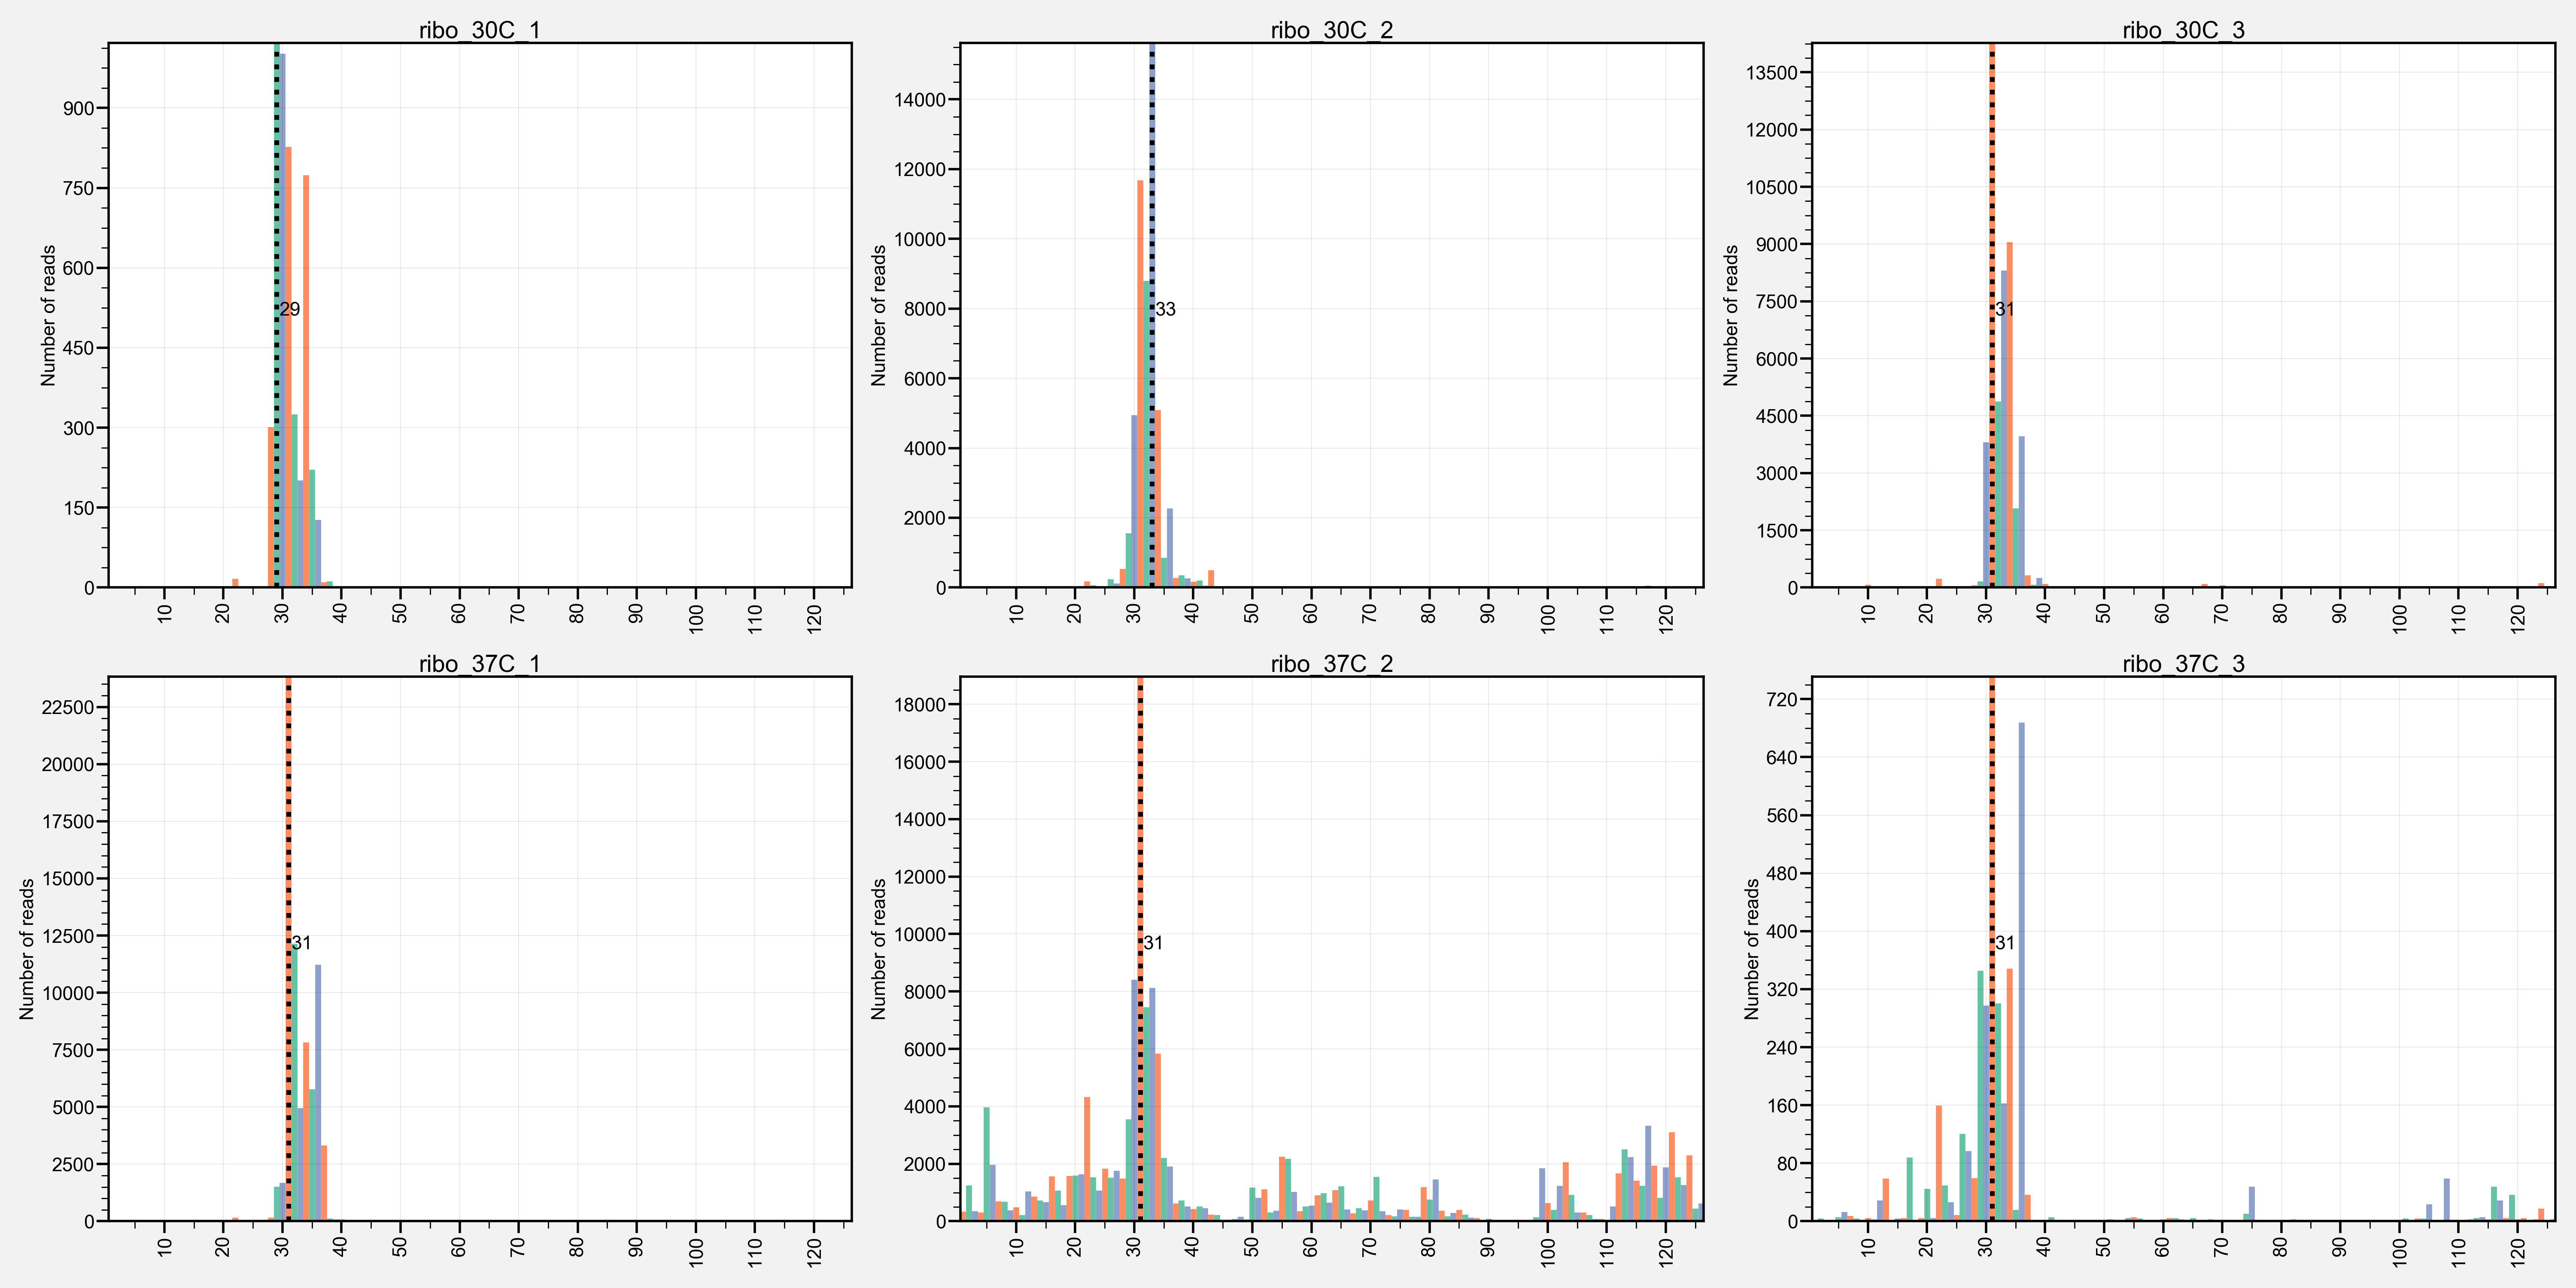

In [26]:
plot_orf_nt('CR_01770C_A-T_403879_404004_126', True)

In [36]:
def plot_orf_codon(orf_id, plot_peaks = False):
    fig = plt.figure(figsize=(30, 15))
    if plot_peaks:
        row = codon_peaks_df.loc[orf_id]
        values_30C = row[['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']].values
        values_37C = row[['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']].values
        intersecting_peaks_30C = list(set(values_30C[0]).intersection(*values_30C))
        intersecting_peaks_37C = list(set(values_37C[0]).intersection(*values_37C))
    
        
    for index, key in enumerate(['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']):
        ax = fig.add_subplot(2,3,index+1)
        profile = samplewise_codon_profiles.loc[orf_id, key]
        length = len(profile)
        ax.set_title(key)
        plot_framewise_codon(pd.Series(profile, index=range(1, length+1)),
                          ax=ax)
        if plot_peaks:
            if '30C' in key:
                ax.set_ylim(0, max(profile)*1.1)
                for peak in intersecting_peaks_30C:
                    ax.plot(peak+1, profile[peak]+1, marker='^', color='r', markersize=15)
                    ax.text(y=profile[peak], x=1.5+peak, s=peak+1)
                    ax.set_ylim(0, max(profile)*1.15)
            elif '37C' in key:
                ax.set_ylim(0, max(profile)*1.1)
                for peak in intersecting_peaks_37C:
                    ax.plot(peak+1, profile[peak]+1, marker='^', color='r', markersize=15)
                    ax.text(y=profile[peak], x=1.5+peak, s=peak+1)
                    
        #ax.get_legend().remove()
    fig.tight_layout()

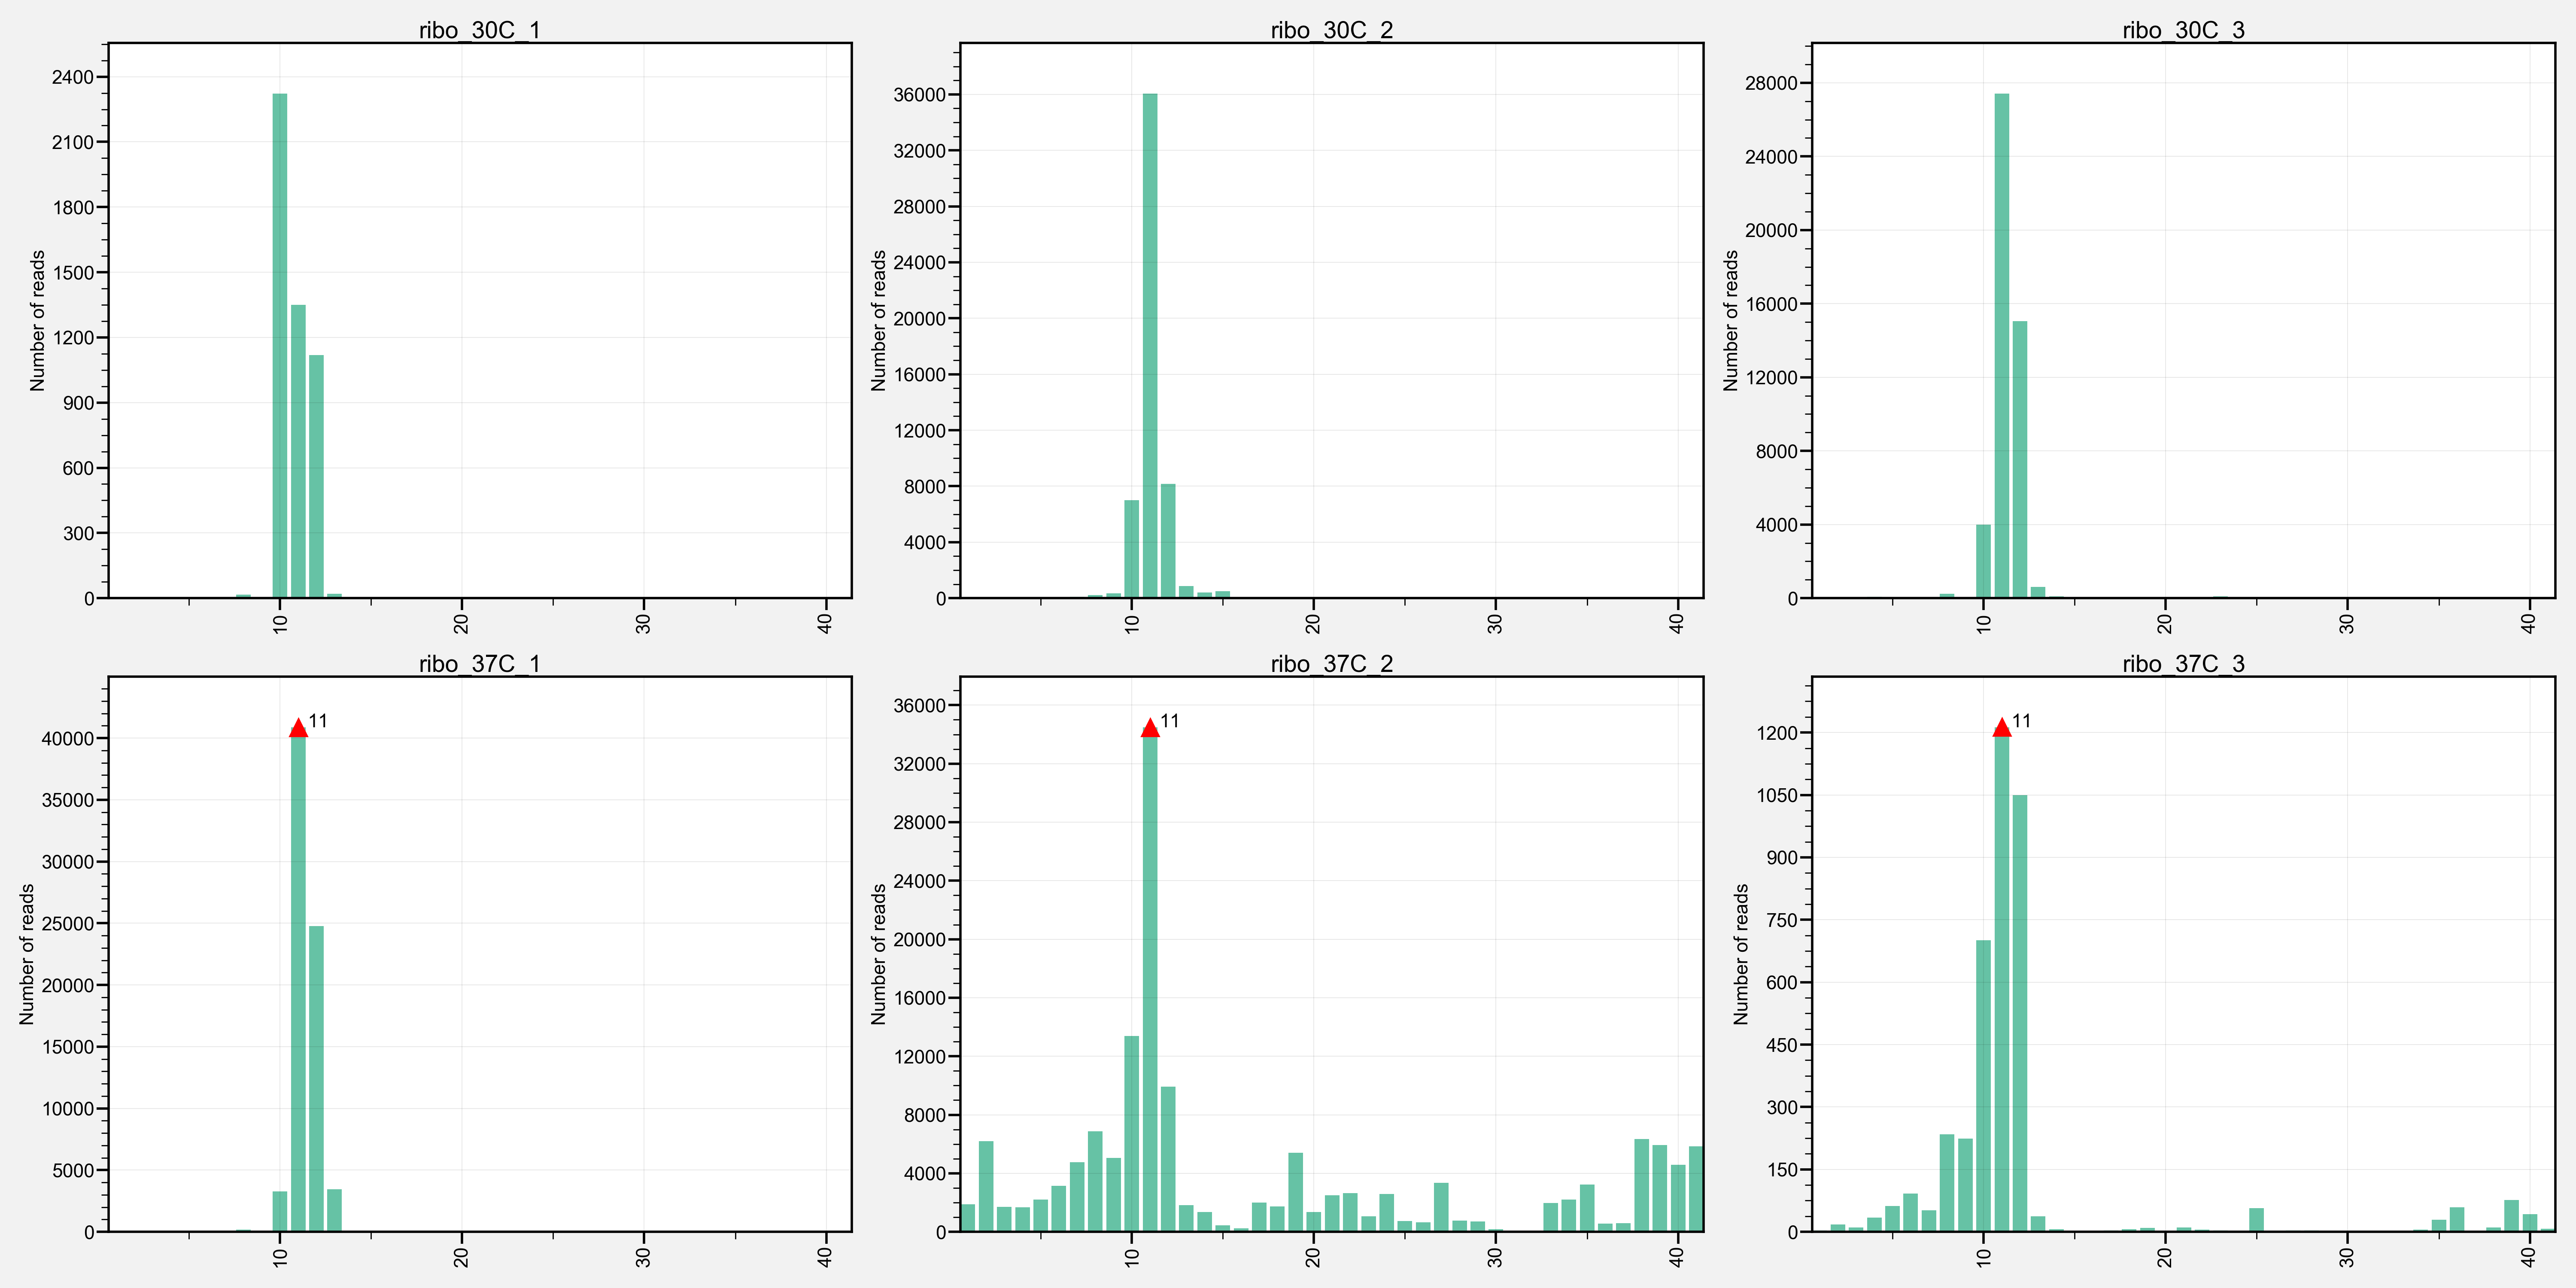

In [37]:
plot_orf_codon('CR_01770C_A-T_403879_404004_126', True)

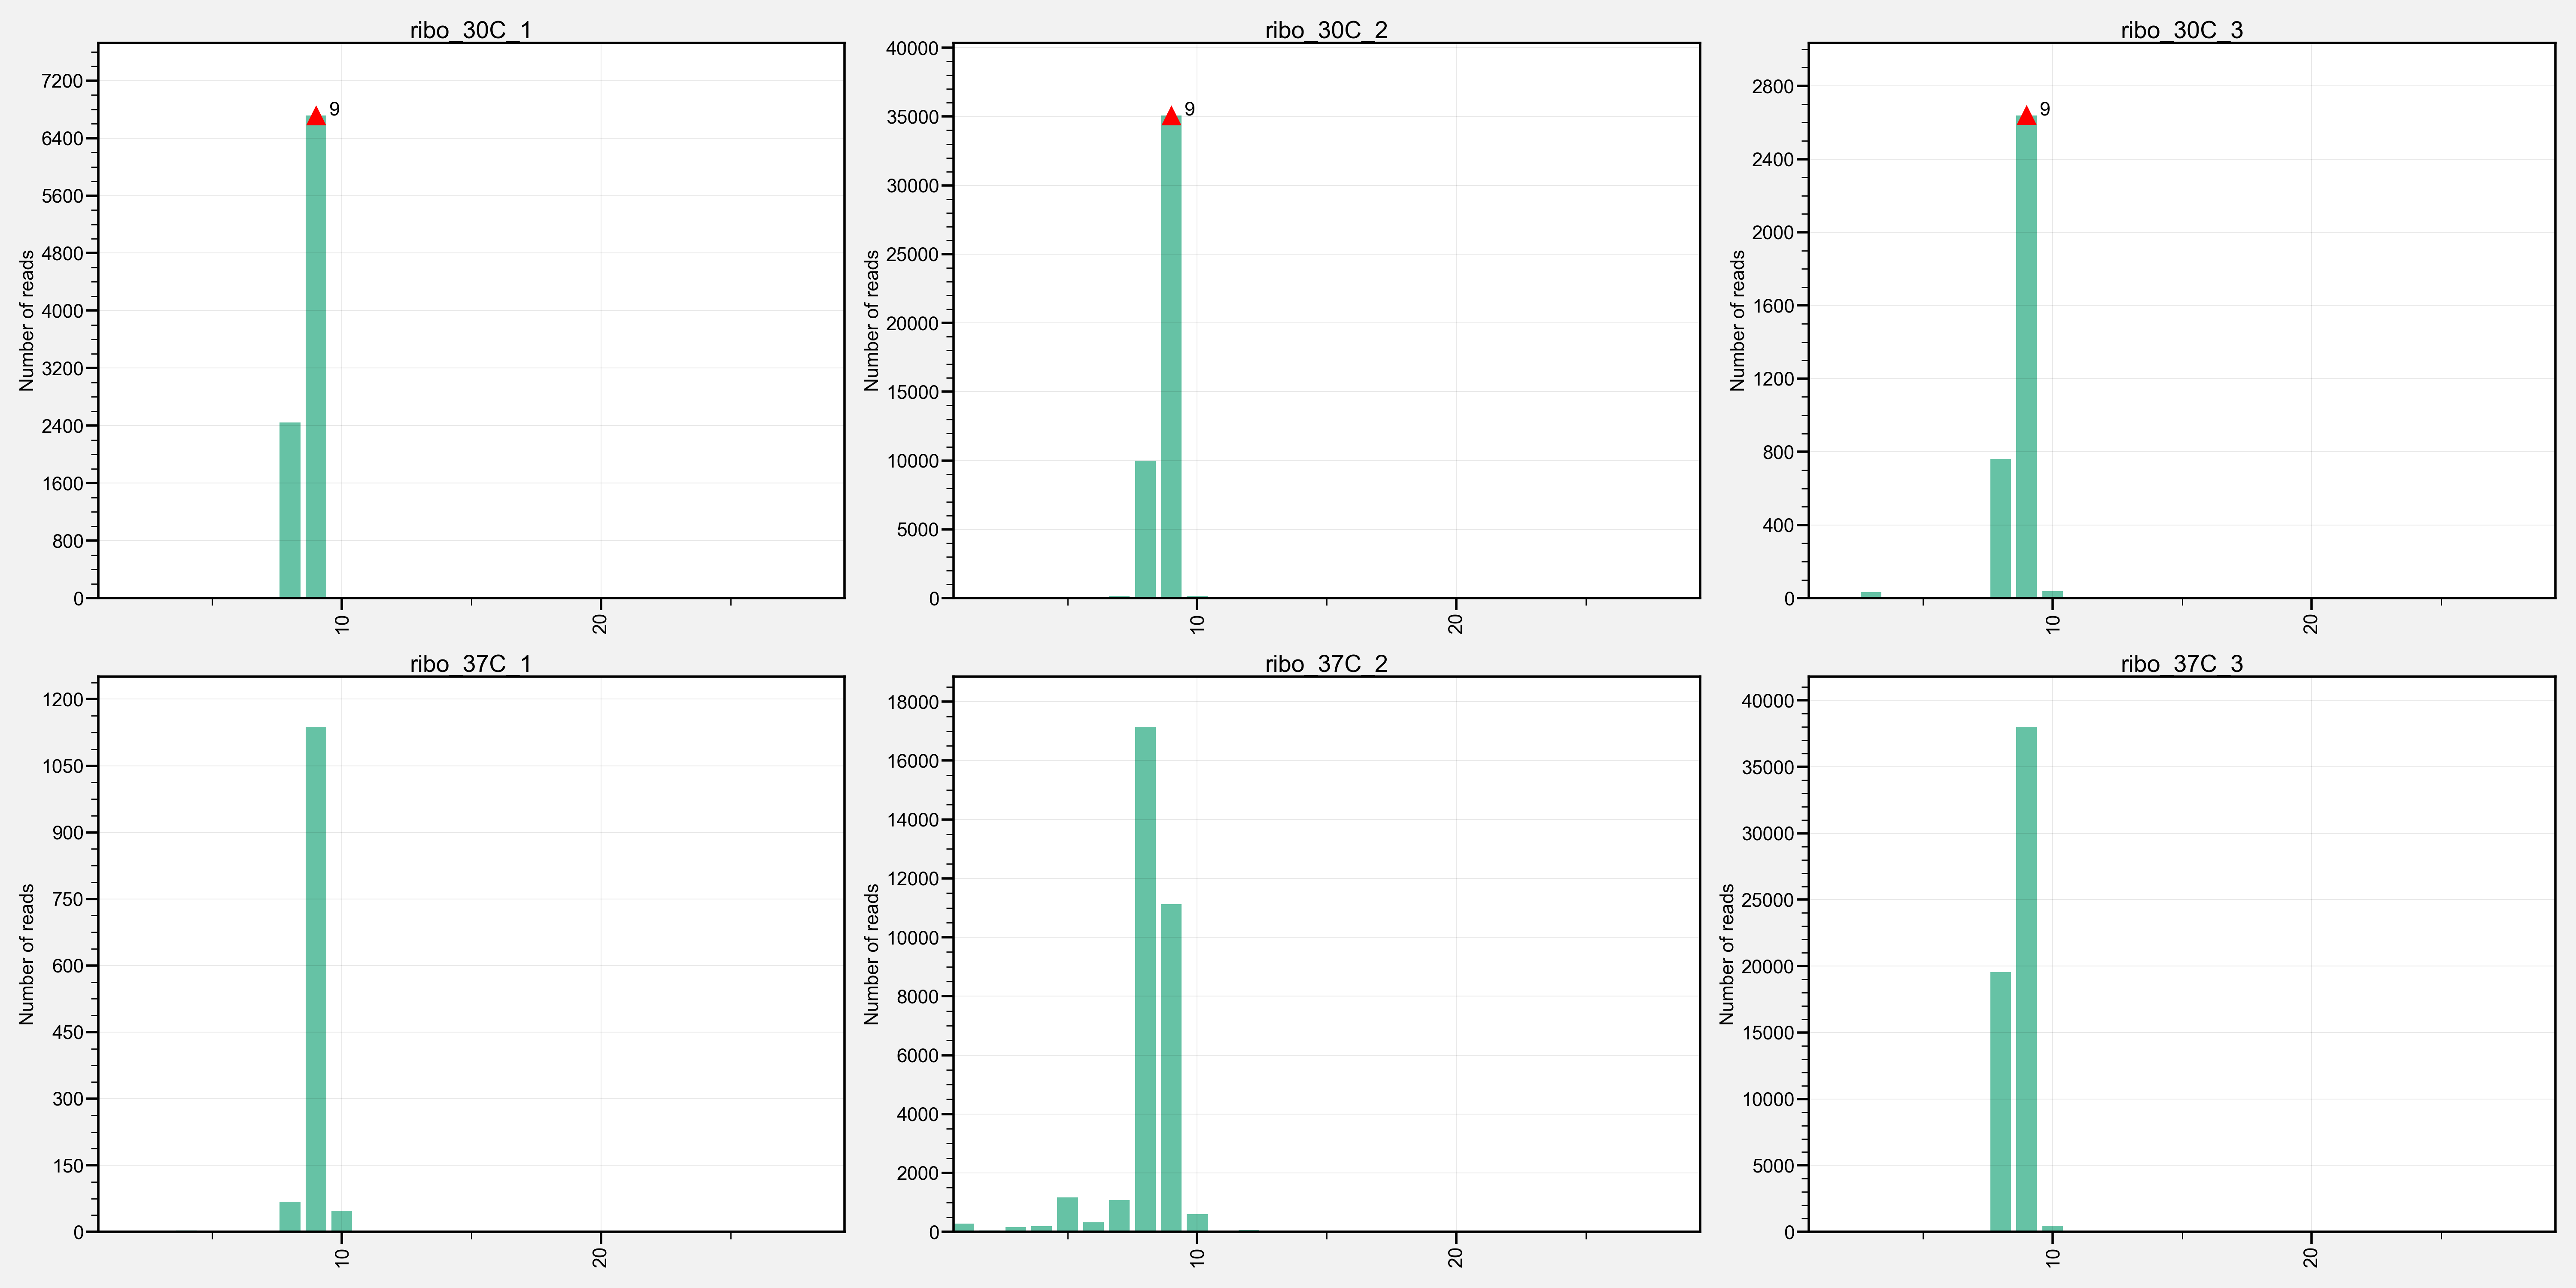

In [38]:
plot_orf_codon('MSTRG.9377.6_1424136_1424225_90', True)

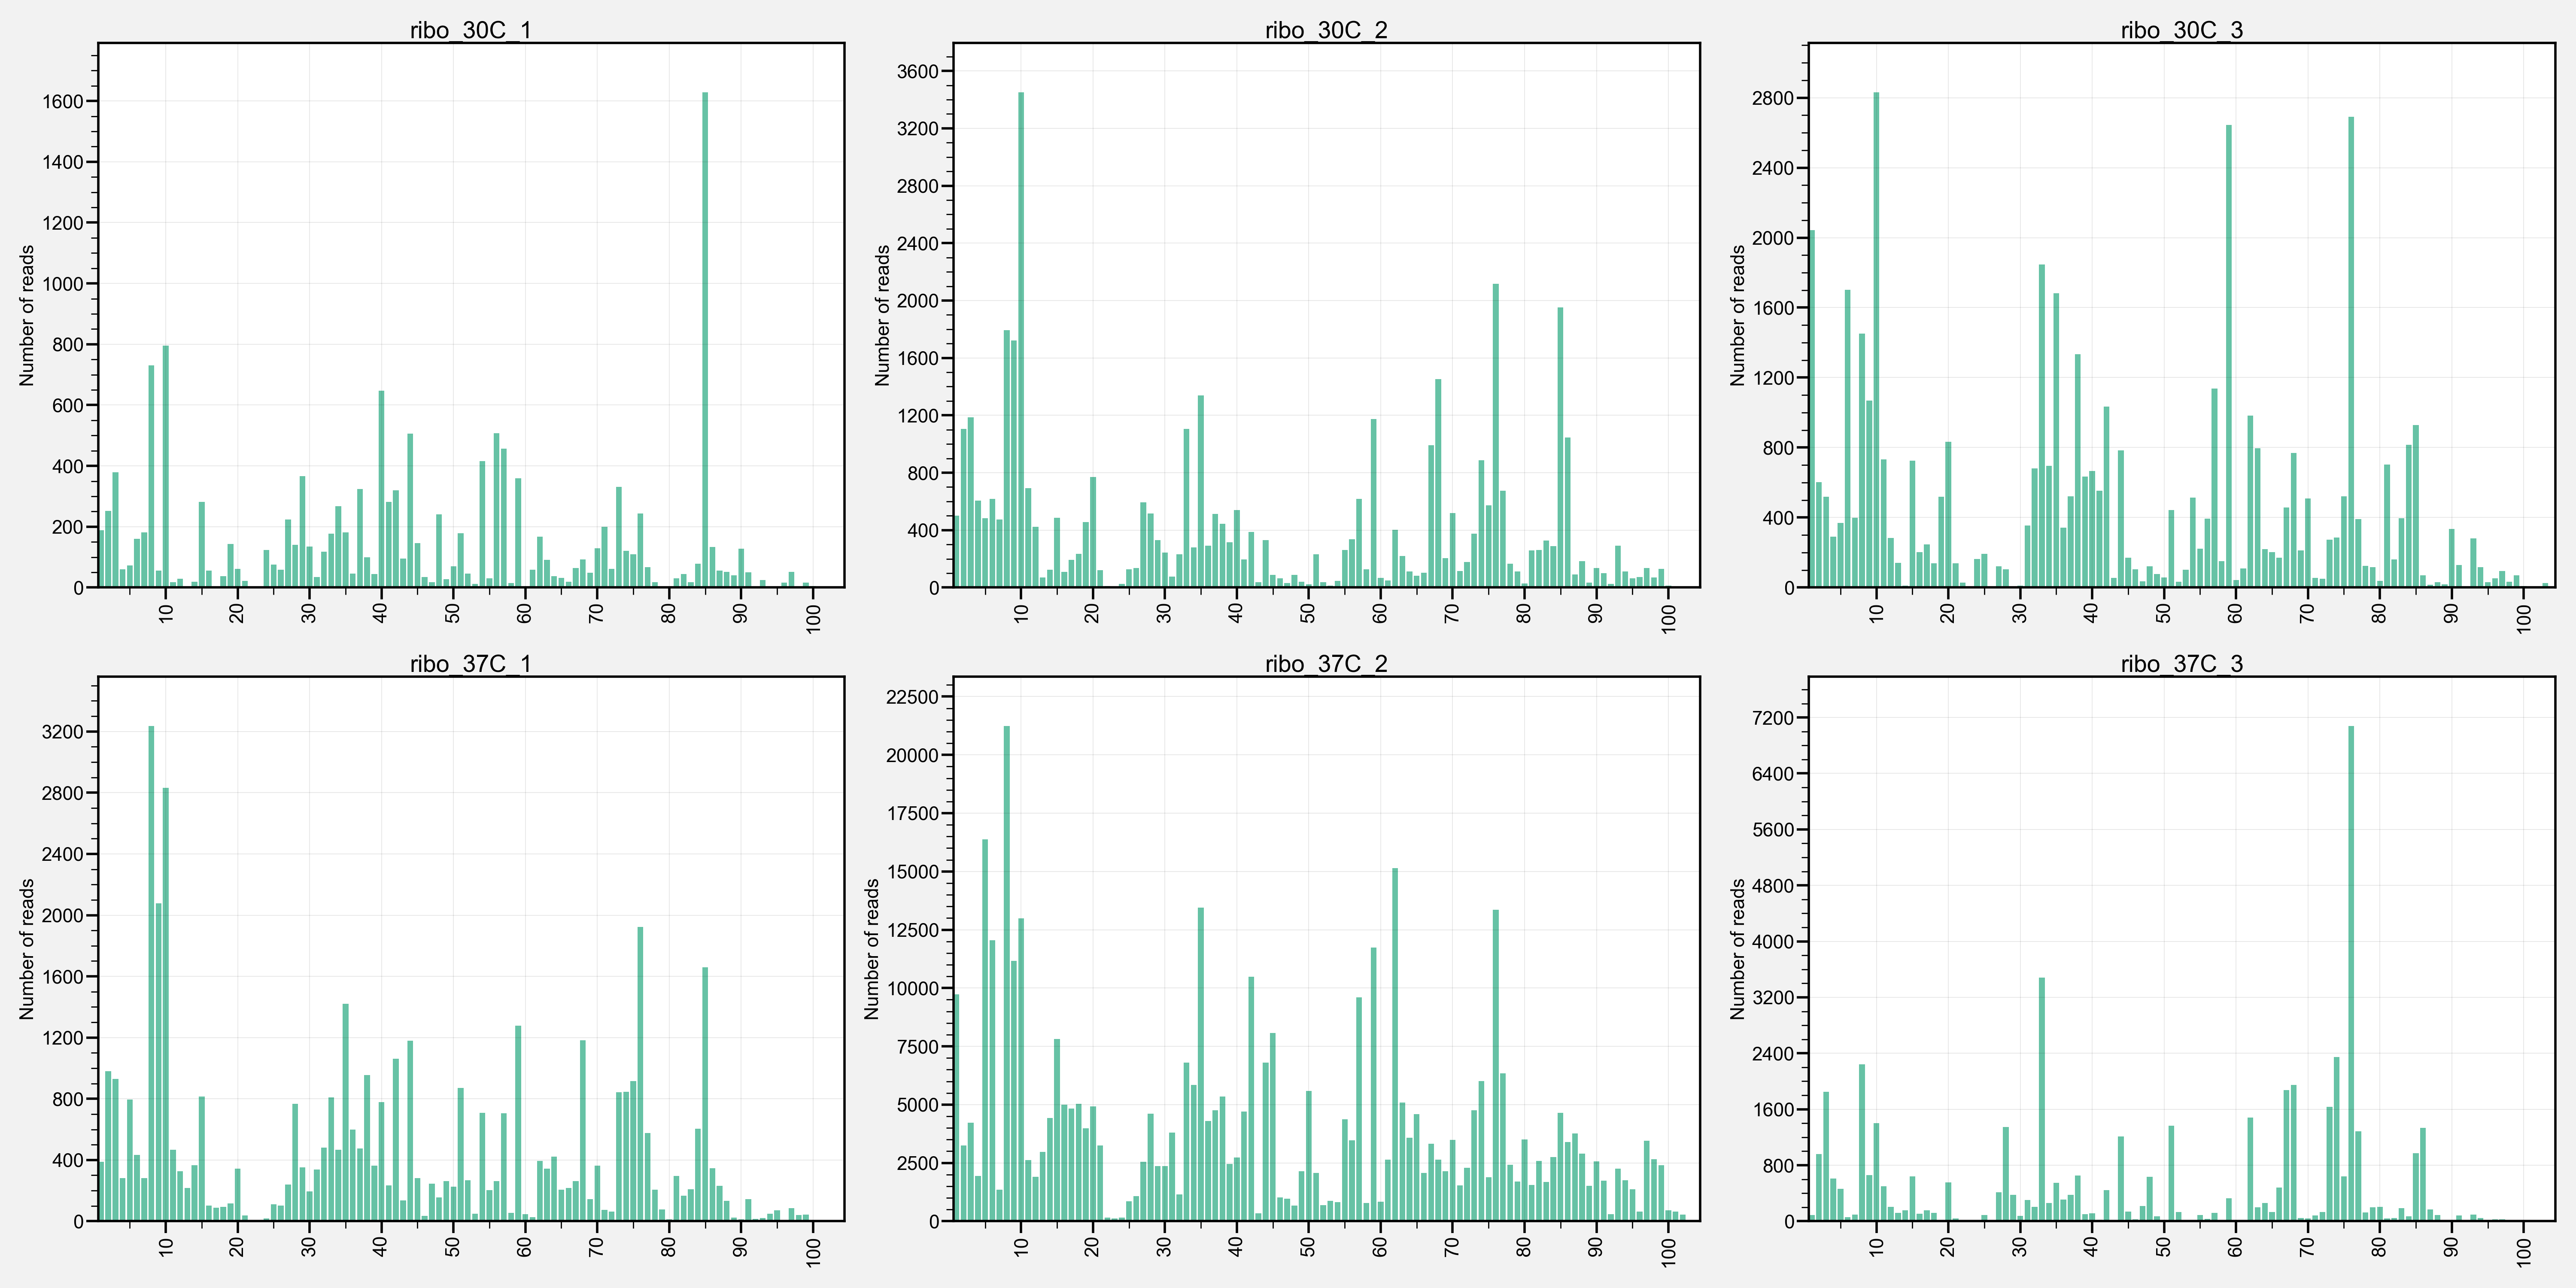

In [39]:
plot_orf_codon('C4_02370C_A-T_470990_471304_315', True)

# Consistent peaks

In [40]:
orf_ids_with_consistent_peaks_30C = []
orf_ids_with_consistent_peaks_37C = []

for idx, row in codon_peaks_df.iterrows():
    values_30C = row[['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']].values
    values_37C = row[['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']].values
    
    intersecting_peaks_30C = list(set(values_30C[0]).intersection(*values_30C))
    intersecting_peaks_37C = list(set(values_37C[0]).intersection(*values_37C))
    
    if intersecting_peaks_30C:
        orf_ids_with_consistent_peaks_30C.append((idx, list(intersecting_peaks_30C)))
    if intersecting_peaks_37C:
        orf_ids_with_consistent_peaks_37C.append((idx, list(intersecting_peaks_37C)))
orf_ids_with_consistent_peaks_30C_df = pd.DataFrame(orf_ids_with_consistent_peaks_30C, columns=['ORF_ID', 'peak'])
orf_ids_with_consistent_peaks_37C_df = pd.DataFrame(orf_ids_with_consistent_peaks_37C, columns=['ORF_ID', 'peak'])    
    
orf_ids_with_consistent_peaks_30C_df.to_csv('../data/pausing_sites/orf_ids_with_consistent_peaks_30C_df.tsv', sep='\t', index=False)
orf_ids_with_consistent_peaks_37C_df.to_csv('../data/pausing_sites/orf_ids_with_consistent_peaks_37C_df.tsv', sep='\t', index=False)
    
orf_ids_with_consistent_peaks_30C_df_i = orf_ids_with_consistent_peaks_30C_df.rename(columns = {'peak': 'peak_30C'}).set_index('ORF_ID')
orf_ids_with_consistent_peaks_37C_df_i = orf_ids_with_consistent_peaks_37C_df.rename(columns = {'peak': 'peak_37C'}).set_index('ORF_ID')

peaks_30C_37C_df_combined = orf_ids_with_consistent_peaks_30C_df_i.join(orf_ids_with_consistent_peaks_37C_df_i, how='outer')    

In [114]:
samplewise_codon_profiles.head()

peak_30C peak_37C
ORF_ID                                          
C1_00140W_A-T_22270_25323_3054       []    [520]
C1_00400W_A-T_63202_64347_1146    [291]       []
C1_00450C_A-T_72744_73091_348      [80]       []
C1_00590W_A-T_95153_95311_159      [49]       []
C1_00590W_A-T_95214_96491_1278    [250]       []

peak_30C peak_37C  \
ORF_ID                                               
C1_00140W_A-T_22270_25323_3054         []    [520]   
C1_00400W_A-T_63202_64347_1146      [291]       []   
C1_00450C_A-T_72744_73091_348        [80]       []   
C1_00590W_A-T_95153_95311_159        [49]       []   
C1_00590W_A-T_95214_96491_1278      [250]       []   
...                                   ...      ...   
MSTRG.2.1_1746_1982_237                []     [32]   
MSTRG.9377.6_1422562_1422756_195       []     [45]   
MSTRG.9377.6_1422584_1422715_132       []     [38]   
MSTRG.9377.6_1423526_1423639_114       []     [34]   
MSTRG.9377.6_1424136_1424225_90       [8]       []   

                                                                         ribo_30C_1  \
ORF_ID                                                                                
C1_00140W_A-T_22270_25323_3054    [0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
C1_00400W_A-T_63202_64347_1146    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...   
C1_00450C_A-T_72744_73091_348     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ...   
C1_00590W_A-T_95153_95311_159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
C1_00590W_A-T_95214_96491_1278    [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, ...   
...                                                                             ...   
MSTRG.2.1_1746_1982_237           [0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1422562_1422756_195  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1422584_1422715_132  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1423526_1423639_114  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1424136_1424225_90   [0, 0, 0, 1, 0, 0, 0, 2441, 6716, 0, 0, 0, 0, ...   

                                                                         ribo_30C_2  \
ORF_ID                                                                                
C1_00140W_A-T_22270_25323_3054    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   
C1_00400W_A-T_63202_64347_1146    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
C1_00450C_A-T_72744_73091_348     [0, 0, 0, 0, 0, 0, 5, 0, 17, 0, 5, 0, 0, 3, 0,...   
C1_00590W_A-T_95153_95311_159     [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
C1_00590W_A-T_95214_96491_1278    [13, 0, 7, 0, 1, 5, 0, 1, 0, 0, 0, 0, 12, 9, 0...   
...                                                                             ...   
MSTRG.2.1_1746_1982_237           [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1422562_1422756_195  [0, 0, 0, 6, 0, 0, 0, 4, 0, 4, 6, 13, 4, 0, 0,...   
MSTRG.9377.6_1422584_1422715_132  [4, 3, 1, 6, 14, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
MSTRG.9377.6_1423526_1423639_114  [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1424136_1424225_90   [0, 0, 8, 44, 32, 26, 151, 9994, 35086, 163, 4...   

                                                                         ribo_30C_3  \
ORF_ID                                                                                
C1_00140W_A-T_22270_25323_3054    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
C1_00400W_A-T_63202_64347_1146    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...   
C1_00450C_A-T_72744_73091_348     [0, 0, 0, 0, 10, 0, 1, 0, 13, 0, 0, 0, 0, 1, 0...   
C1_00590W_A-T_95153_95311_159     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
C1_00590W_A-T_95214_96491_1278    [10, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 4,...   
...                                                                             ...   
MSTRG.2.1_1746_1982_237           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1422562_1422756_195  [0, 0, 0, 1, 0, 2, 0, 0, 30, 0, 0, 4, 2, 3, 0,...   
MSTRG.9377.6_1422584_1422715_132  [0, 30, 0, 1, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,...   
MSTRG.9377.6_1423526_1423639_114  [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...   
MSTRG.9377.6_1424136_1

In [41]:
peaks_30C_37C_df_consistent = []
peaks_30C_37C_df_differential = []
for idx, row in peaks_30C_37C_df_combined.iterrows():
    if np.isnan(row['peak_30C']).any():
        row['peak_30C'] = []
    if np.isnan(row['peak_37C']).any():
        row['peak_37C'] = []

    intersection = list(set(row['peak_30C']).intersection(set(row['peak_37C'])))
    if intersection:
        peaks_30C_37C_df_consistent.append((idx, intersection))
    else:
        peak_30C_notin37C = list(set(row['peak_30C']).difference(set(row['peak_37C'])))
        peak_37C_notin30C = list(set(row['peak_37C']).difference(set(row['peak_30C'])))
        
        peaks_30C_37C_df_differential.append((idx, peak_30C_notin37C, peak_37C_notin30C))
        
peaks_30C_37C_df_differential_df = pd.DataFrame(peaks_30C_37C_df_differential, columns=['ORF_ID', 'peak_30C', 'peak_37C'])
peaks_30C_37C_df_differential_df.to_csv('../data/pausing_sites/peaks_30C_37C_df_differential.tsv', sep='\t', index=False)

peaks_30C_37C_df_consistent_df = pd.DataFrame(peaks_30C_37C_df_consistent, columns=['ORF_ID', 'peak'])
peaks_30C_37C_df_consistent_df.to_csv('../data/pausing_sites/peaks_30C_37C_df_consistent.tsv', sep='\t', index=False)

In [120]:
peaks_30C_37C_df_combined_tpm_desc

gene_id peak_30C  \
ORF_ID                                                                        
C1_00140W_A-T_22270_25323_3054                           C1_00140W       []   
C1_00400W_A-T_63202_64347_1146                           C1_00400W    [291]   
C1_00450C_A-T_72744_73091_348                            C1_00450C     [80]   
C1_00590W_A-T_95214_96491_1278                           C1_00590W    [250]   
C1_00590W_A-T_95153_95311_159                            C1_00590W     [49]   
...                                                            ...      ...   
MSTRG.2.1_1746_1982_237                    MSTRG.2.1_1746_1982_237       []   
MSTRG.9377.6_1422562_1422756_195  MSTRG.9377.6_1422562_1422756_195       []   
MSTRG.9377.6_1422584_1422715_132  MSTRG.9377.6_1422584_1422715_132       []   
MSTRG.9377.6_1423526_1423639_114  MSTRG.9377.6_1423526_1423639_114       []   
MSTRG.9377.6_1424136_1424225_90    MSTRG.9377.6_1424136_1424225_90      [8]   

                                 peak_37C  ribo_30C_tpm  ribo_37C_tpm  \
ORF_ID                                                                  
C1_00140W_A-T_22270_25323_3054      [520]     33.051667     57.899667   
C1_00400W_A-T_63202_64347_1146         []    104.064667     79.426667   
C1_00450C_A-T_72744_73091_348          []     76.641667     47.438000   
C1_00590W_A-T_95214_96491_1278         []    680.428000    626.529333   
C1_00590W_A-T_95153_95311_159          []    102.748333    303.111667   
...                                   ...           ...           ...   
MSTRG.2.1_1746_1982_237              [32]     28.720667     21.362333   
MSTRG.9377.6_1422562_1422756_195     [45]     24.580667    183.997333   
MSTRG.9377.6_1422584_1422715_132     [38]     30.419667    195.523667   
MSTRG.9377.6_1423526_1423639_114     [34]     15.854667    102.583667   
MSTRG.9377.6_1424136_1424225_90        []  20066.507667  42942.131667   

                                  ribo_30C_37C_avg_tpm  \
ORF_ID                                                   
C1_00140W_A-T_22270_25323_3054               45.475667   
C1_00400W_A-T_63202_64347_1146               91.745667   
C1_00450C_A-T_72744_73091_348                62.039833   
C1_00590W_A-T_95214_96491_1278              653.478667   
C1_00590W_A-T_95153_95311_159               202.930000   
...                                                ...   
MSTRG.2.1_1746_1982_237                      25.041500   
MSTRG.9377.6_1422562_1422756_195            104.289000   
MSTRG.9377.6_1422584_1422715_132            112.971667   
MSTRG.9377.6_1423526_1423639_114             59.219167   
MSTRG.9377.6_1424136_1424225_90           31504.319667   

                                                                        description  \
ORF_ID                                                                                
C1_00140W_A-T_22270_25323_3054    Kelch repeat domain-containing protein; locali...   
C1_00400W_A-T_63202_64347_1146    Putative survival factor; stationary phase enr...   
C1_00450C_A-T_72744_73091_348     Mitochondrial protein; component of the mitoch...   
C1_00590W_A-T_95214_96491_1278    Translation elongation factor TU; macrophage/p...   
C1_00590W_A-T_95153_95311_159     Translation elongation factor TU; macrophage/p...   
...                                                                             ...   
MSTRG.2.1_1746_1982_237                                                         N/A   
MSTRG.9377.6_1422562_1422756_195                                                N/A   
MSTRG.9377.6_1422584_1422715_132                                                N/A   
MSTRG.9377.6_1423526_1423639_114                                                N/A   
MSTRG.9377.6_1424136_1424225_90                                                 N/A   

                                  log2FC_TE_annotated_37C_vs_30C  \
ORF_ID                                                             
C1_00140W_A-T_22270_25323_3054                         -0.

In [124]:
peaks_30C_37C_df_combined_profiles = peaks_30C_37C_df_combined.join(samplewise_codon_profiles)
peaks_30C_37C_df_combined_profiles.to_csv('../data/pausing_sites/peaks_30C_37C_df_combined_profiles.tsv', sep='\t', index=True)

peaks_30C_37C_df_differential_df_profiles = peaks_30C_37C_df_differential_df.set_index('ORF_ID').join(samplewise_codon_profiles)
peaks_30C_37C_df_differential_df_profiles.to_csv('../data/pausing_sites/peaks_30C_37C_df_differential_profiles.tsv', sep='\t', index=True)

peaks_30C_37C_df_consistent_df_profiles = peaks_30C_37C_df_consistent_df.set_index('ORF_ID').join(samplewise_codon_profiles)
peaks_30C_37C_df_consistent_df_profiles.to_csv('../data/pausing_sites/peaks_30C_37C_df_consistent_df_profiles.tsv', sep='\t', index=True)





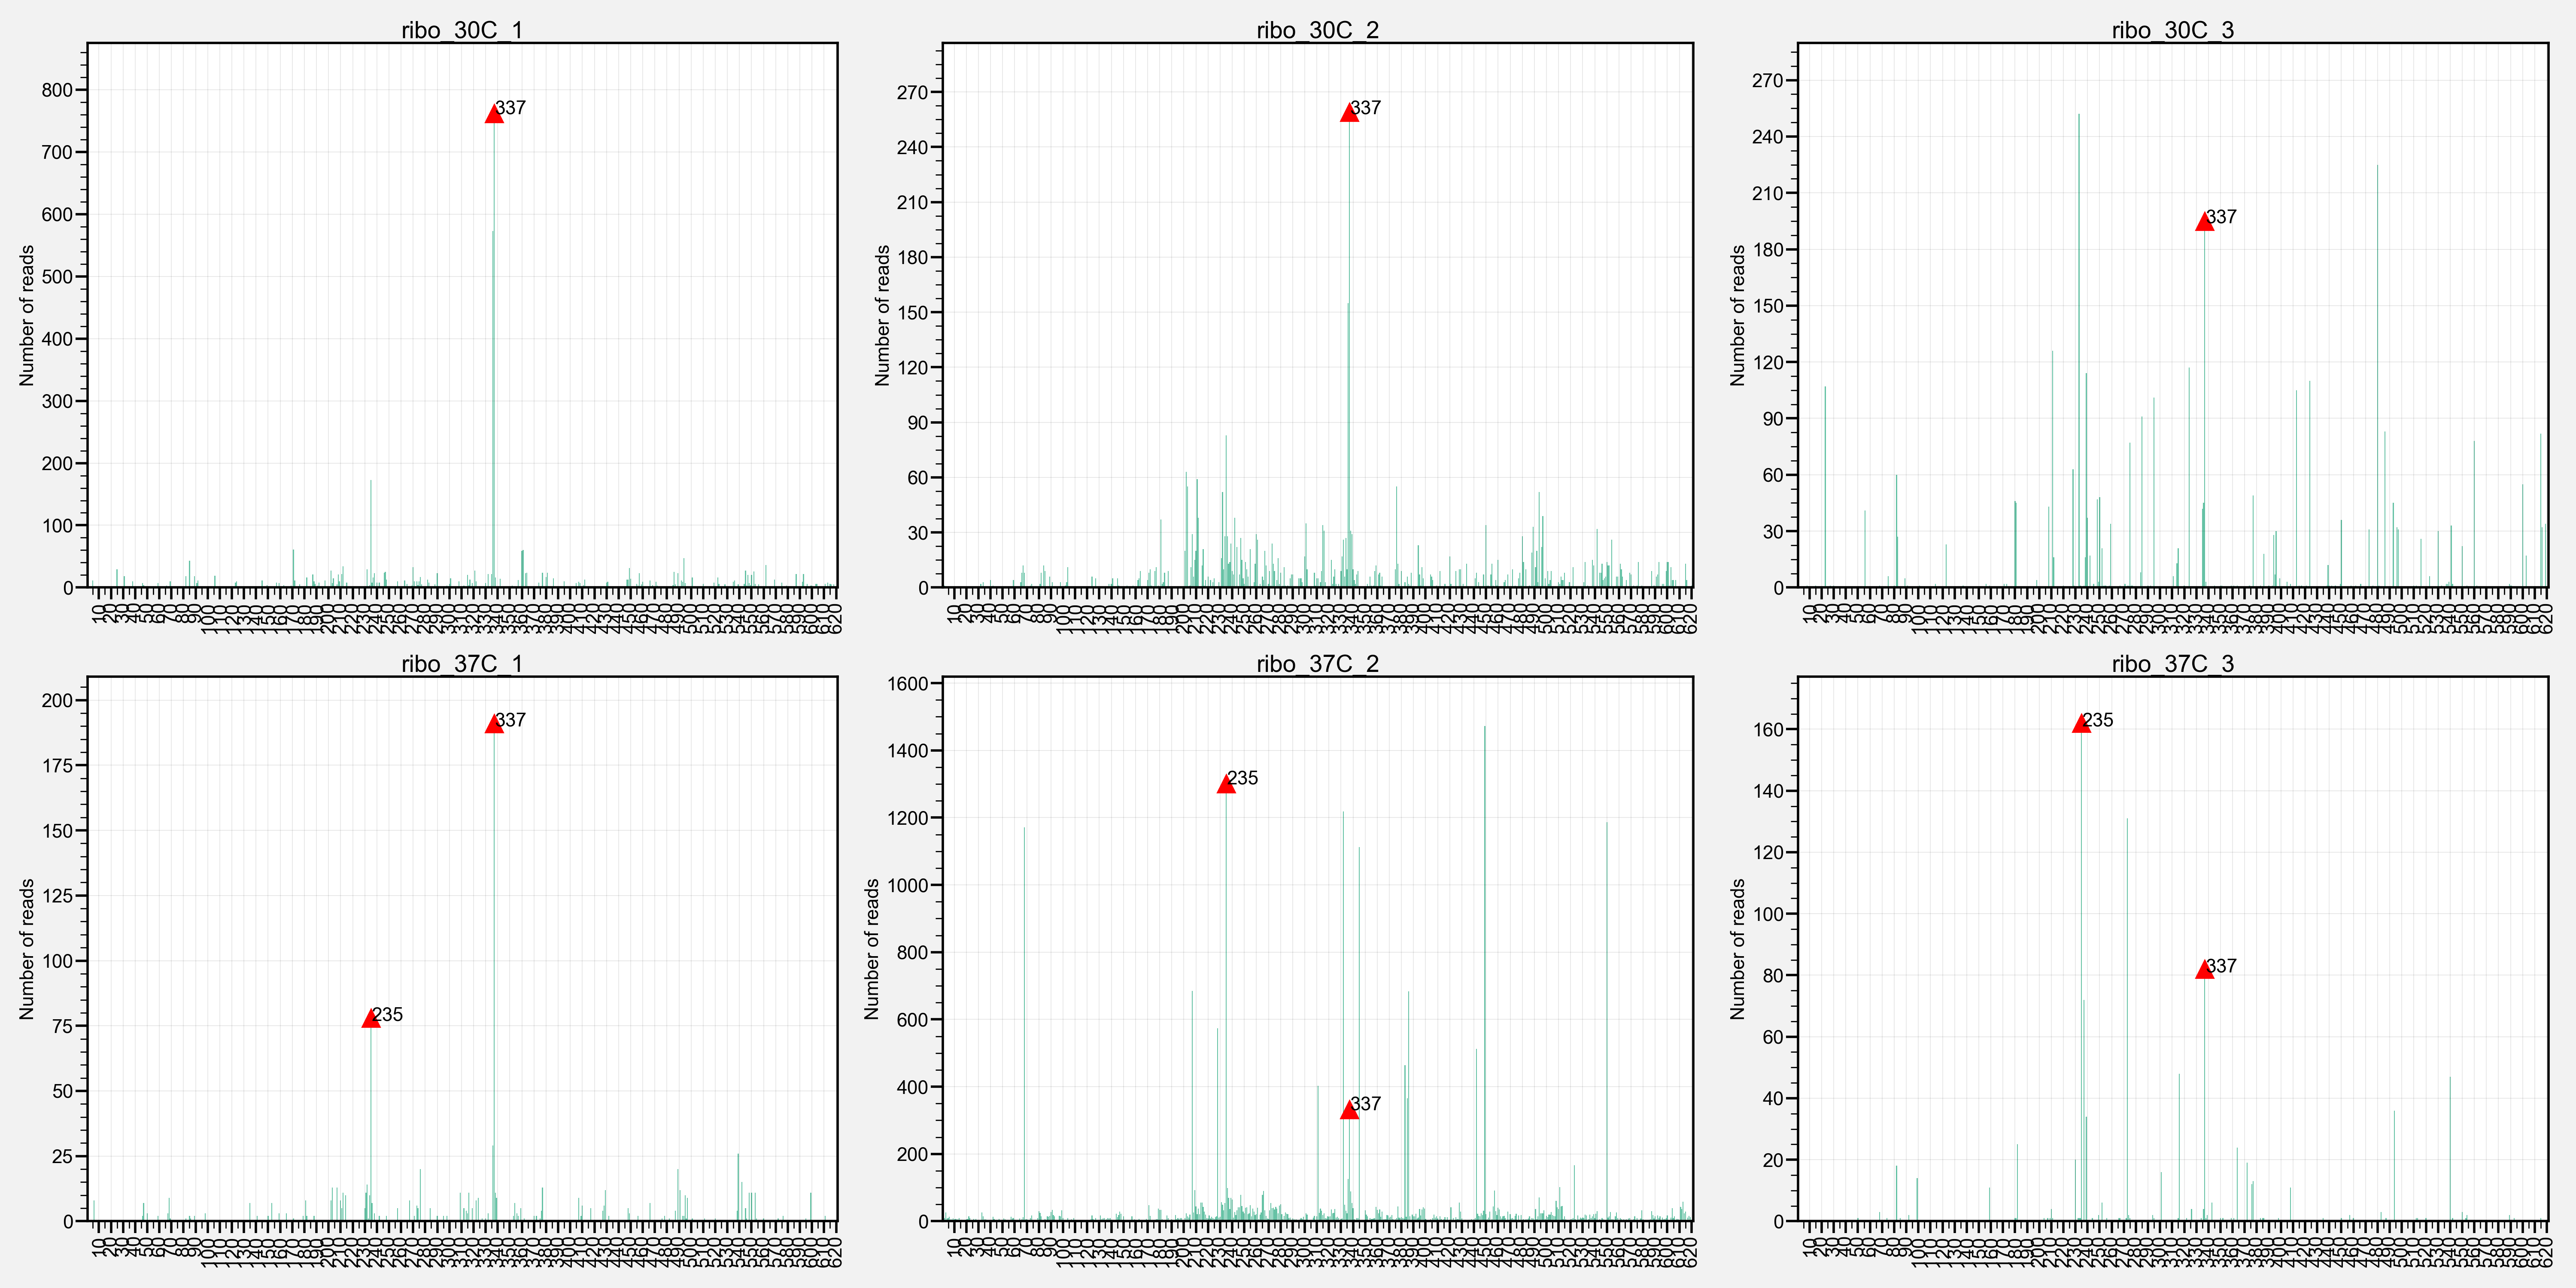

In [42]:
plot_orf_codon('C1_01530C_A-T_306621_308486_1866', True)

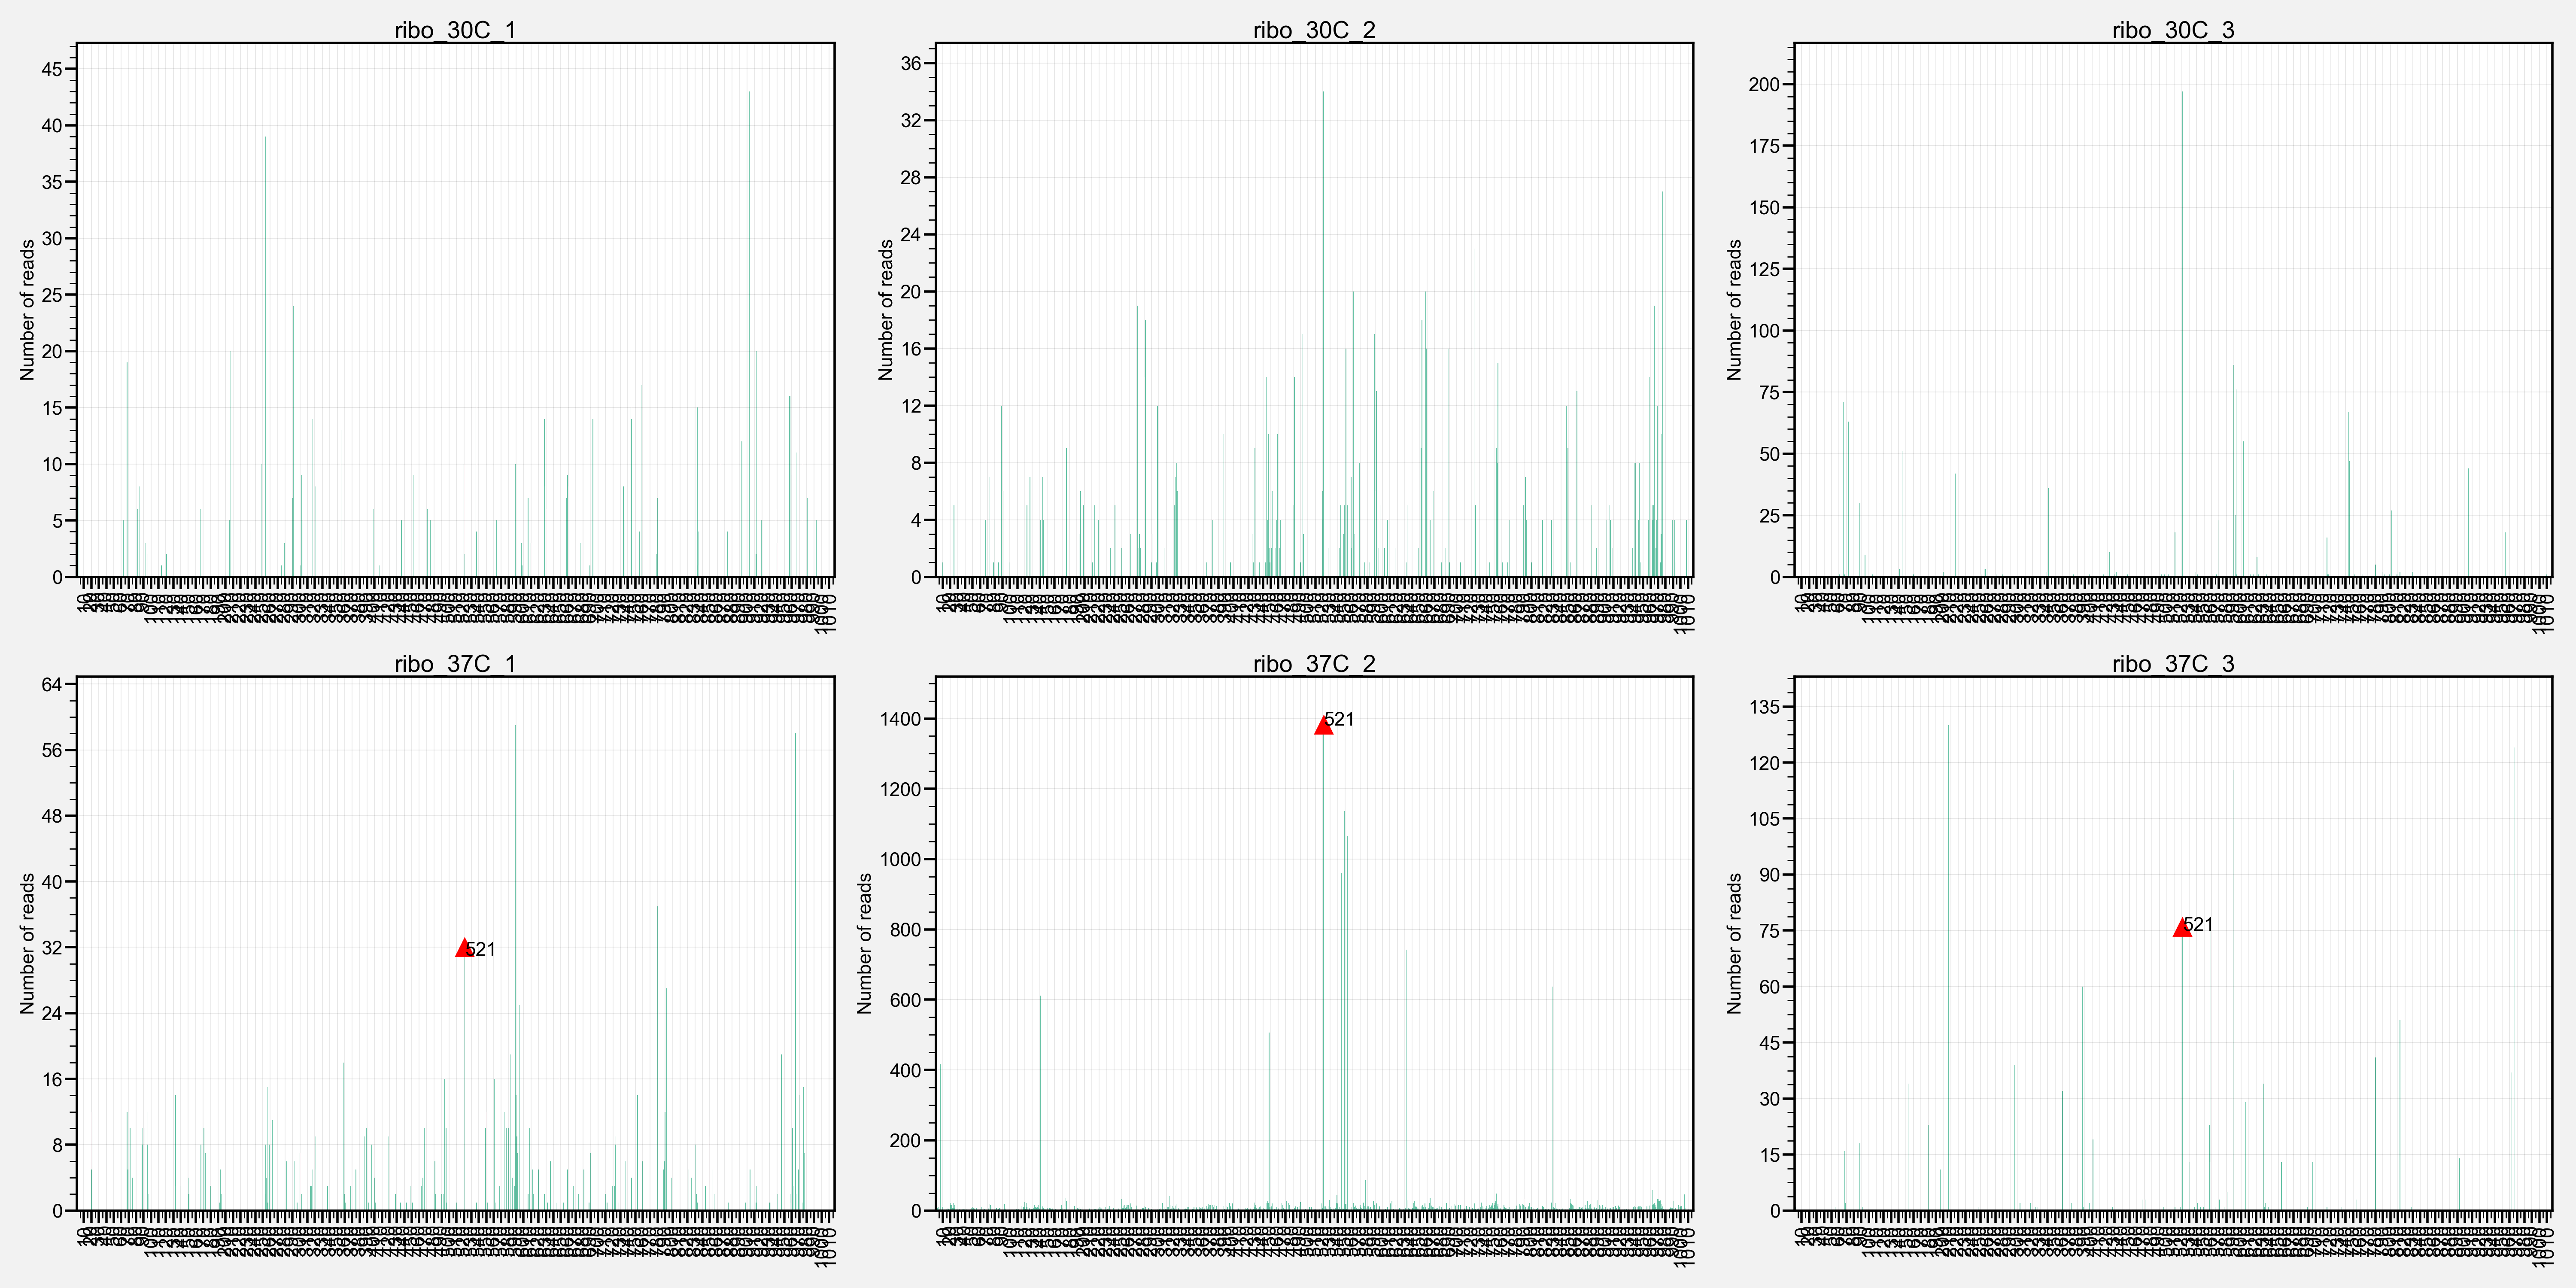

In [43]:
plot_orf_codon('C1_00140W_A-T_22270_25323_3054', True)

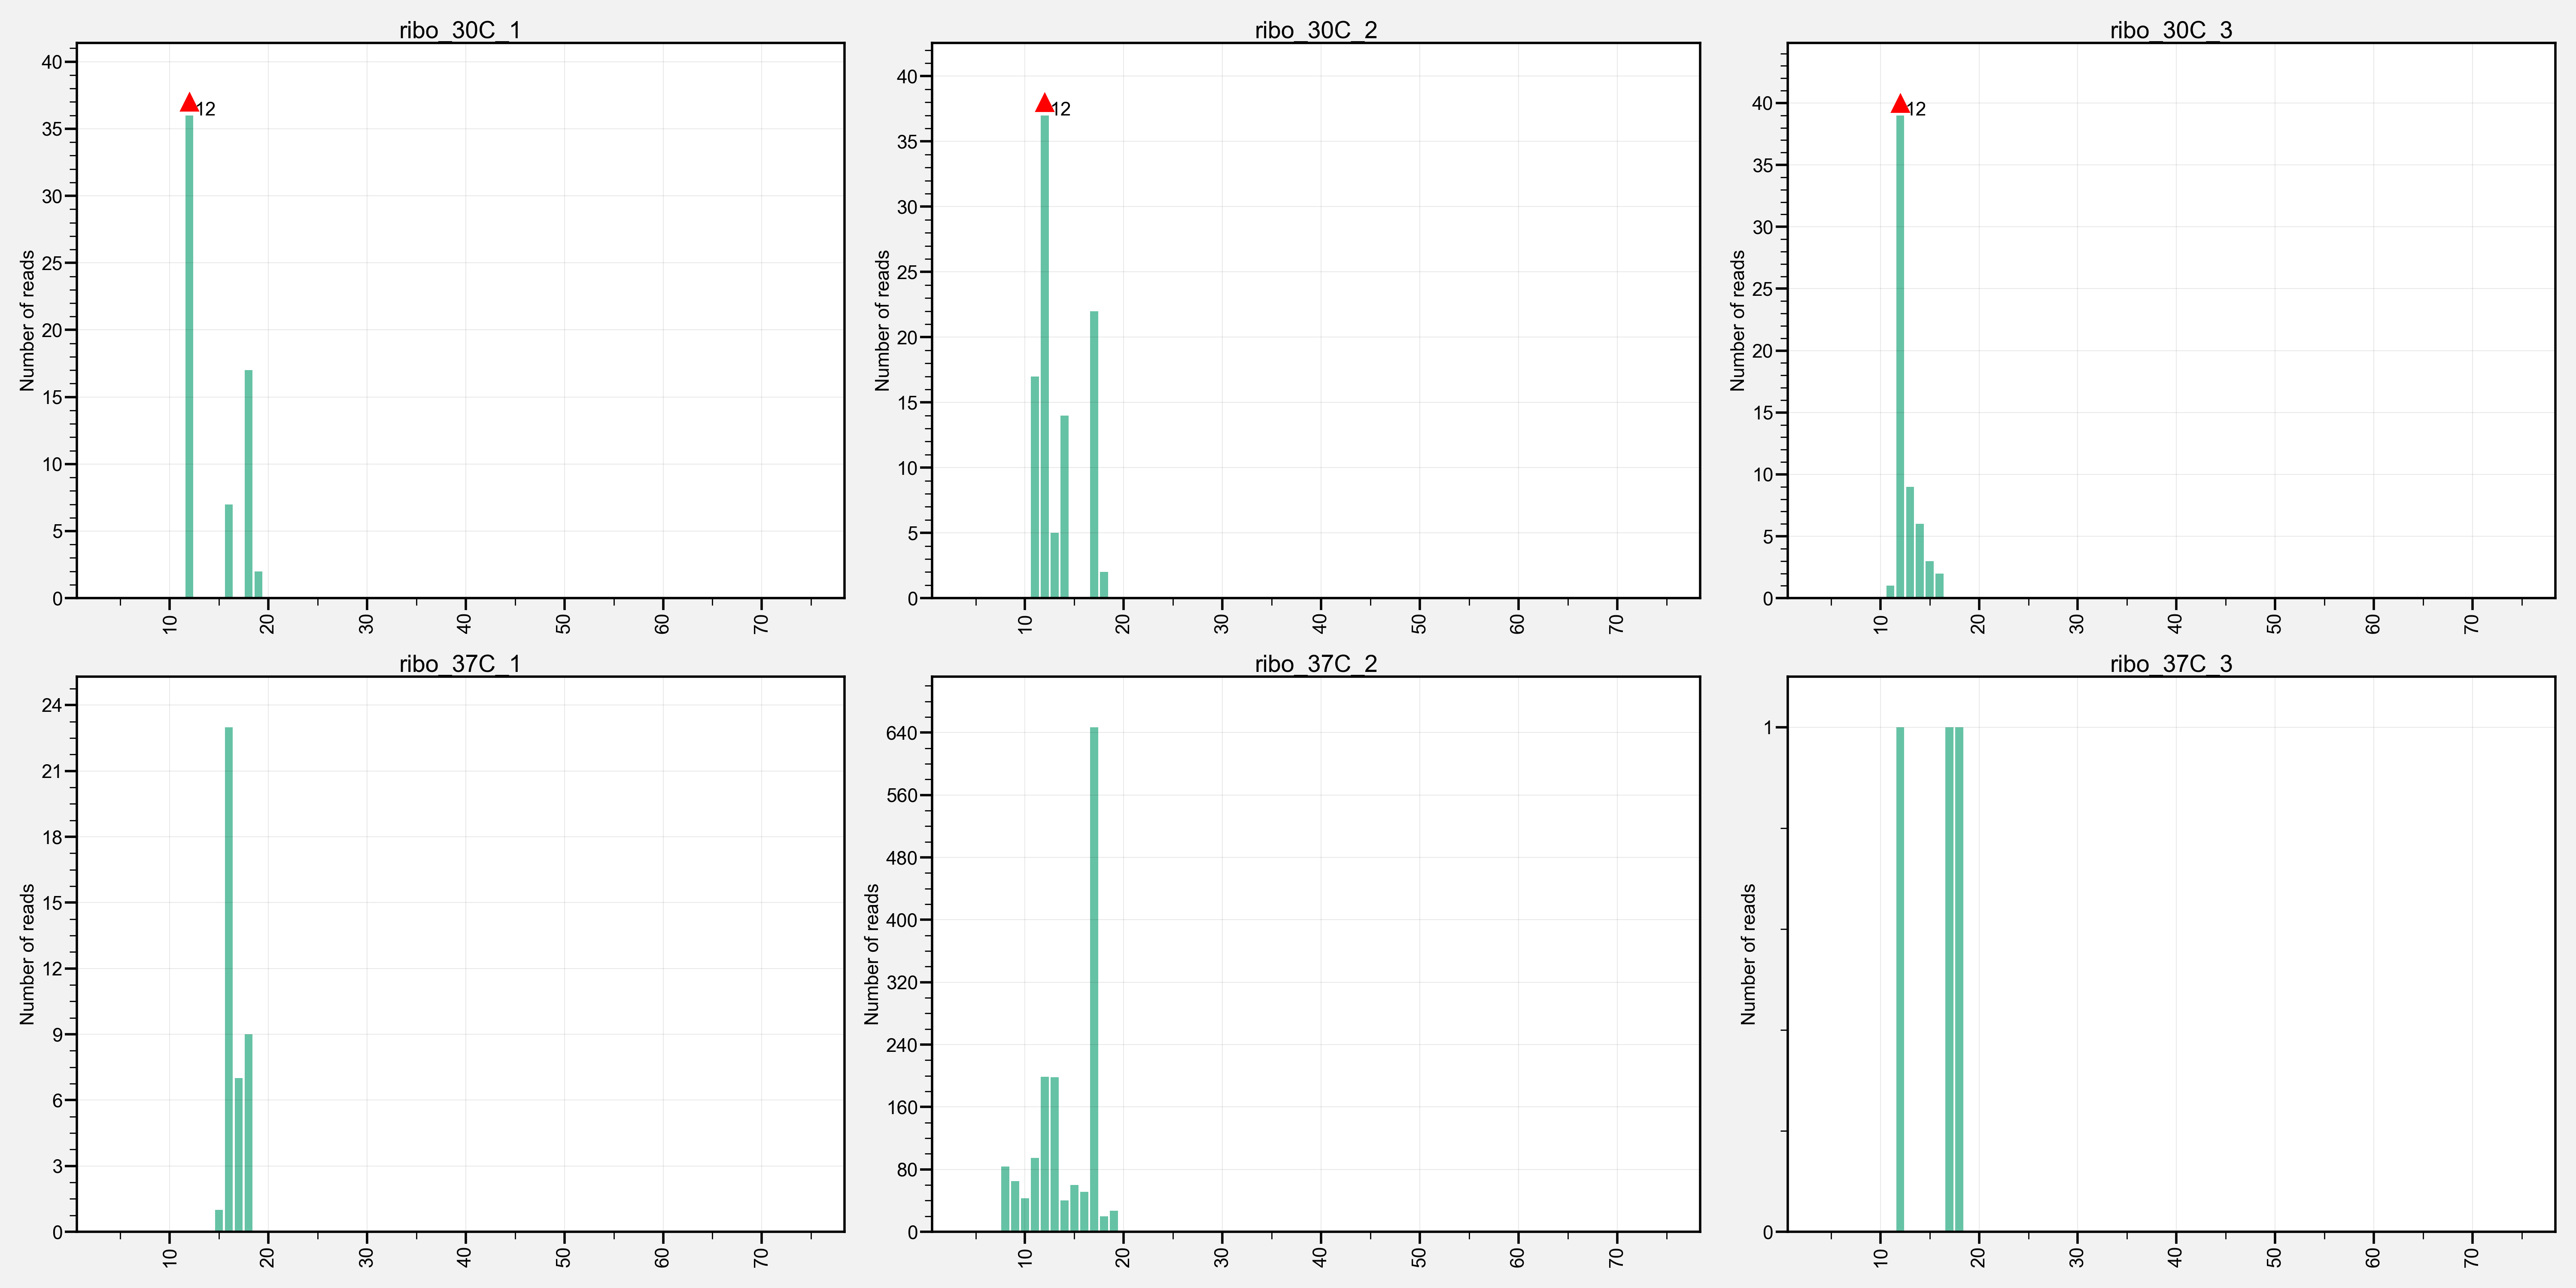

In [44]:
plot_orf_codon('C1_01370C_B-T_269389_269625_237', True)

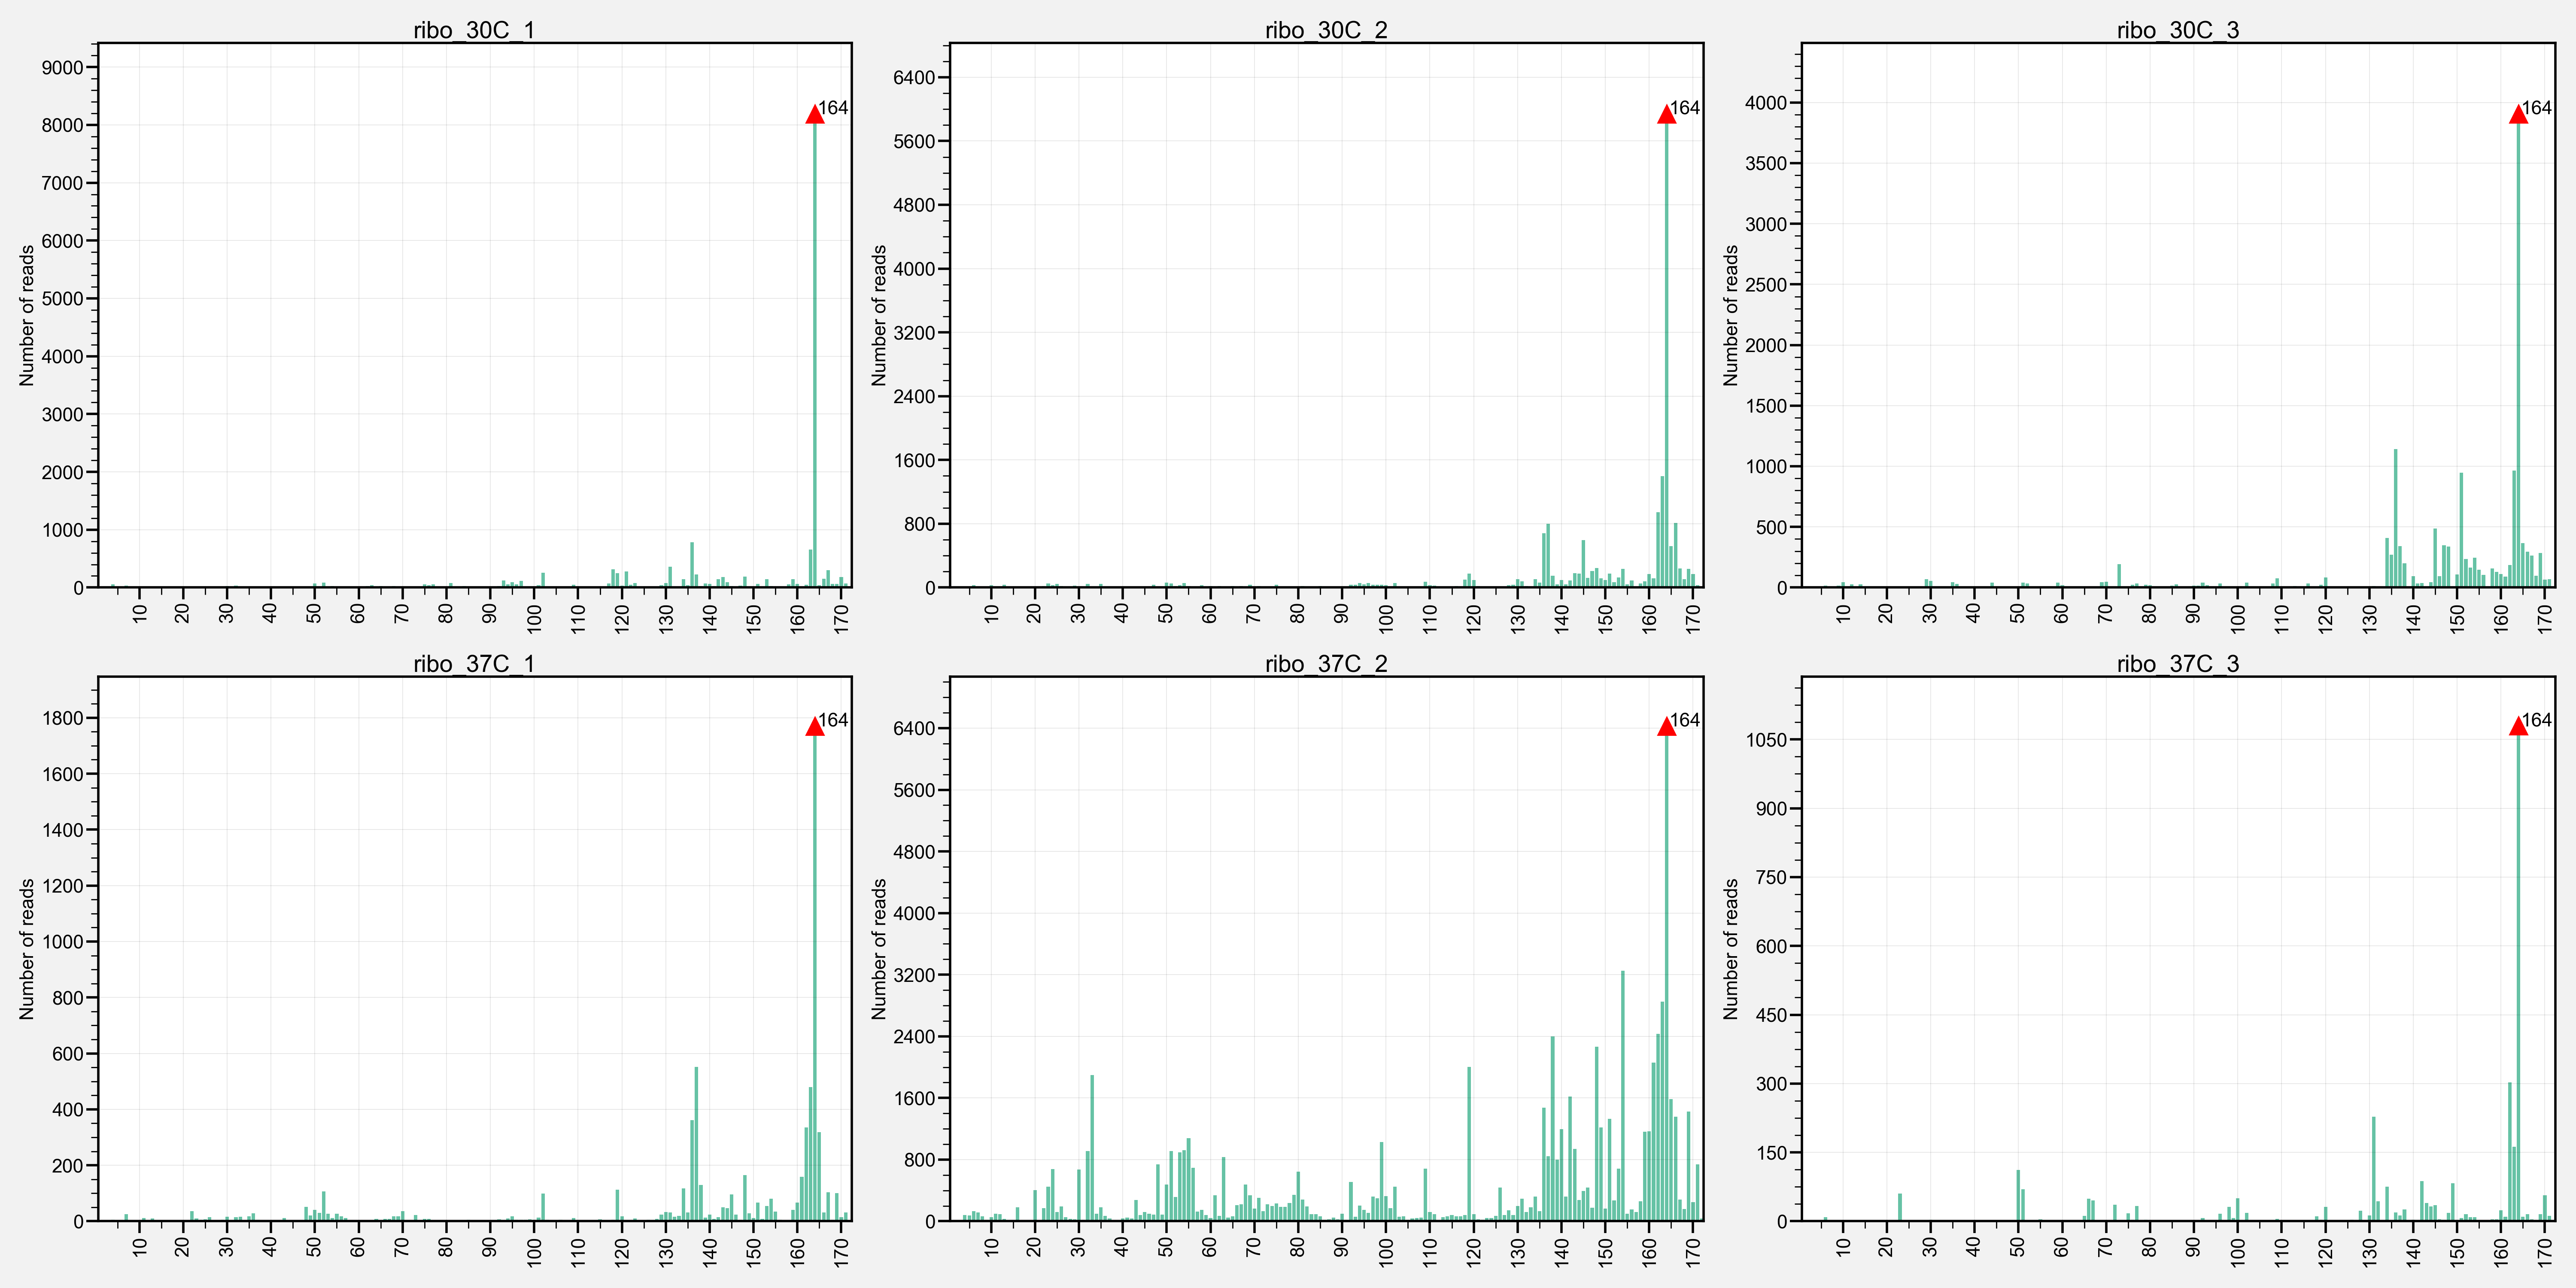

In [45]:
plot_orf_codon('C2_06810C_A-T_1395466_1395984_519', True)

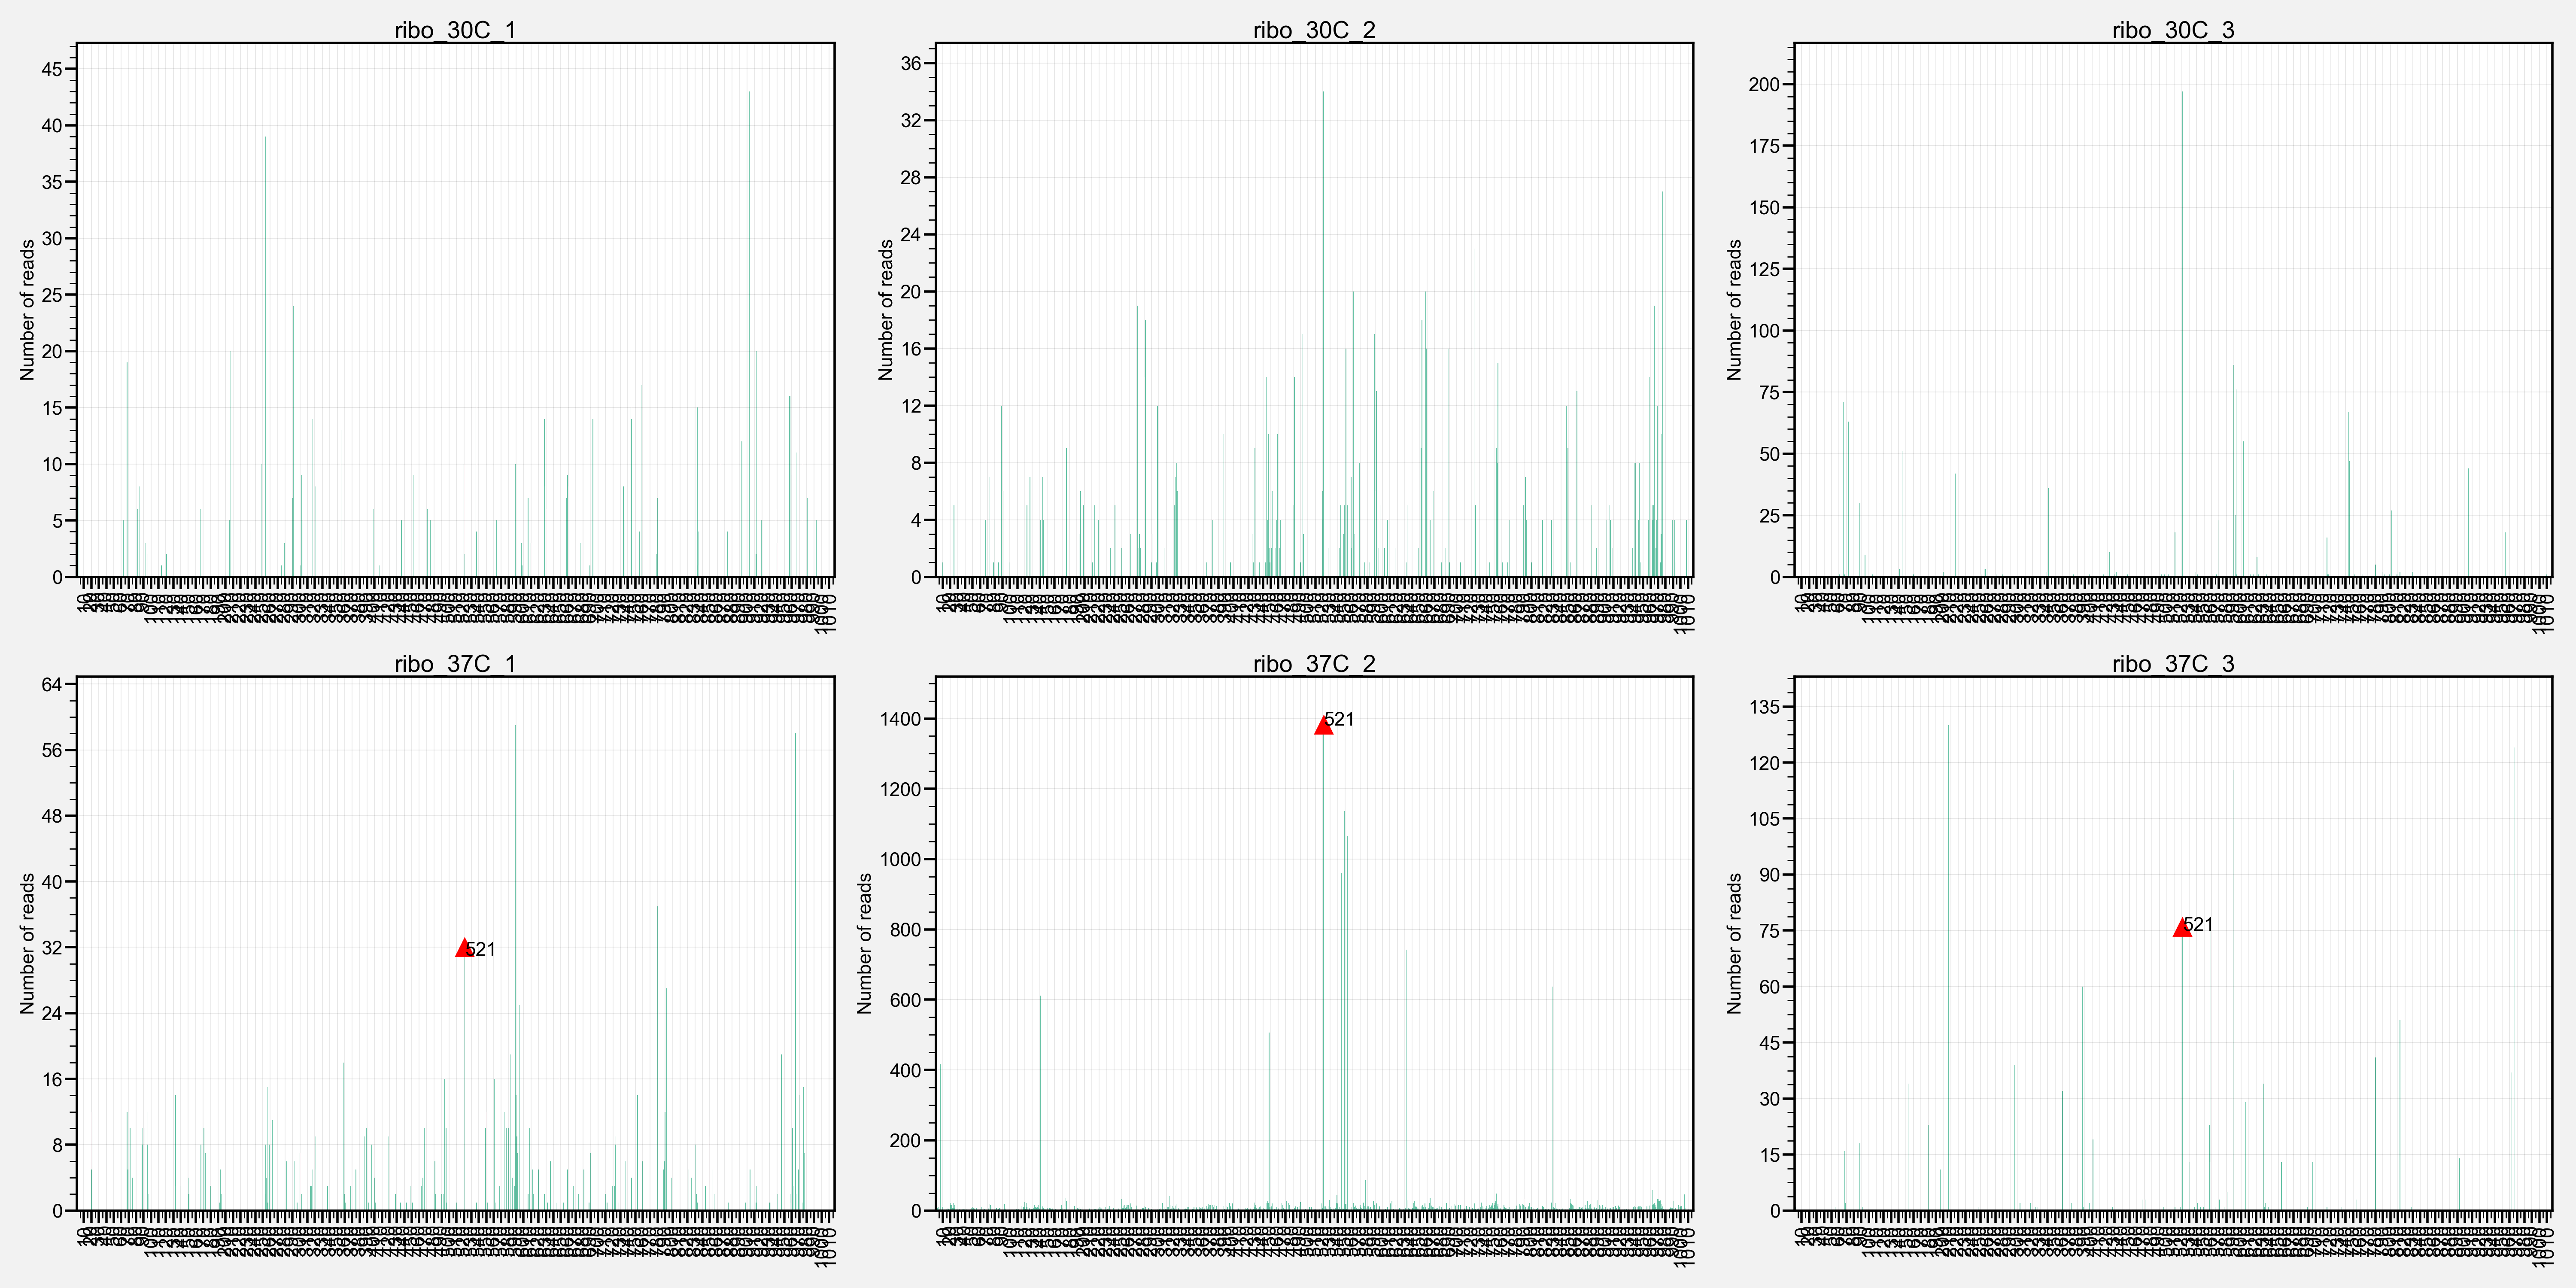

In [121]:
plot_orf_codon('C1_00140W_A-T_22270_25323_3054', True)

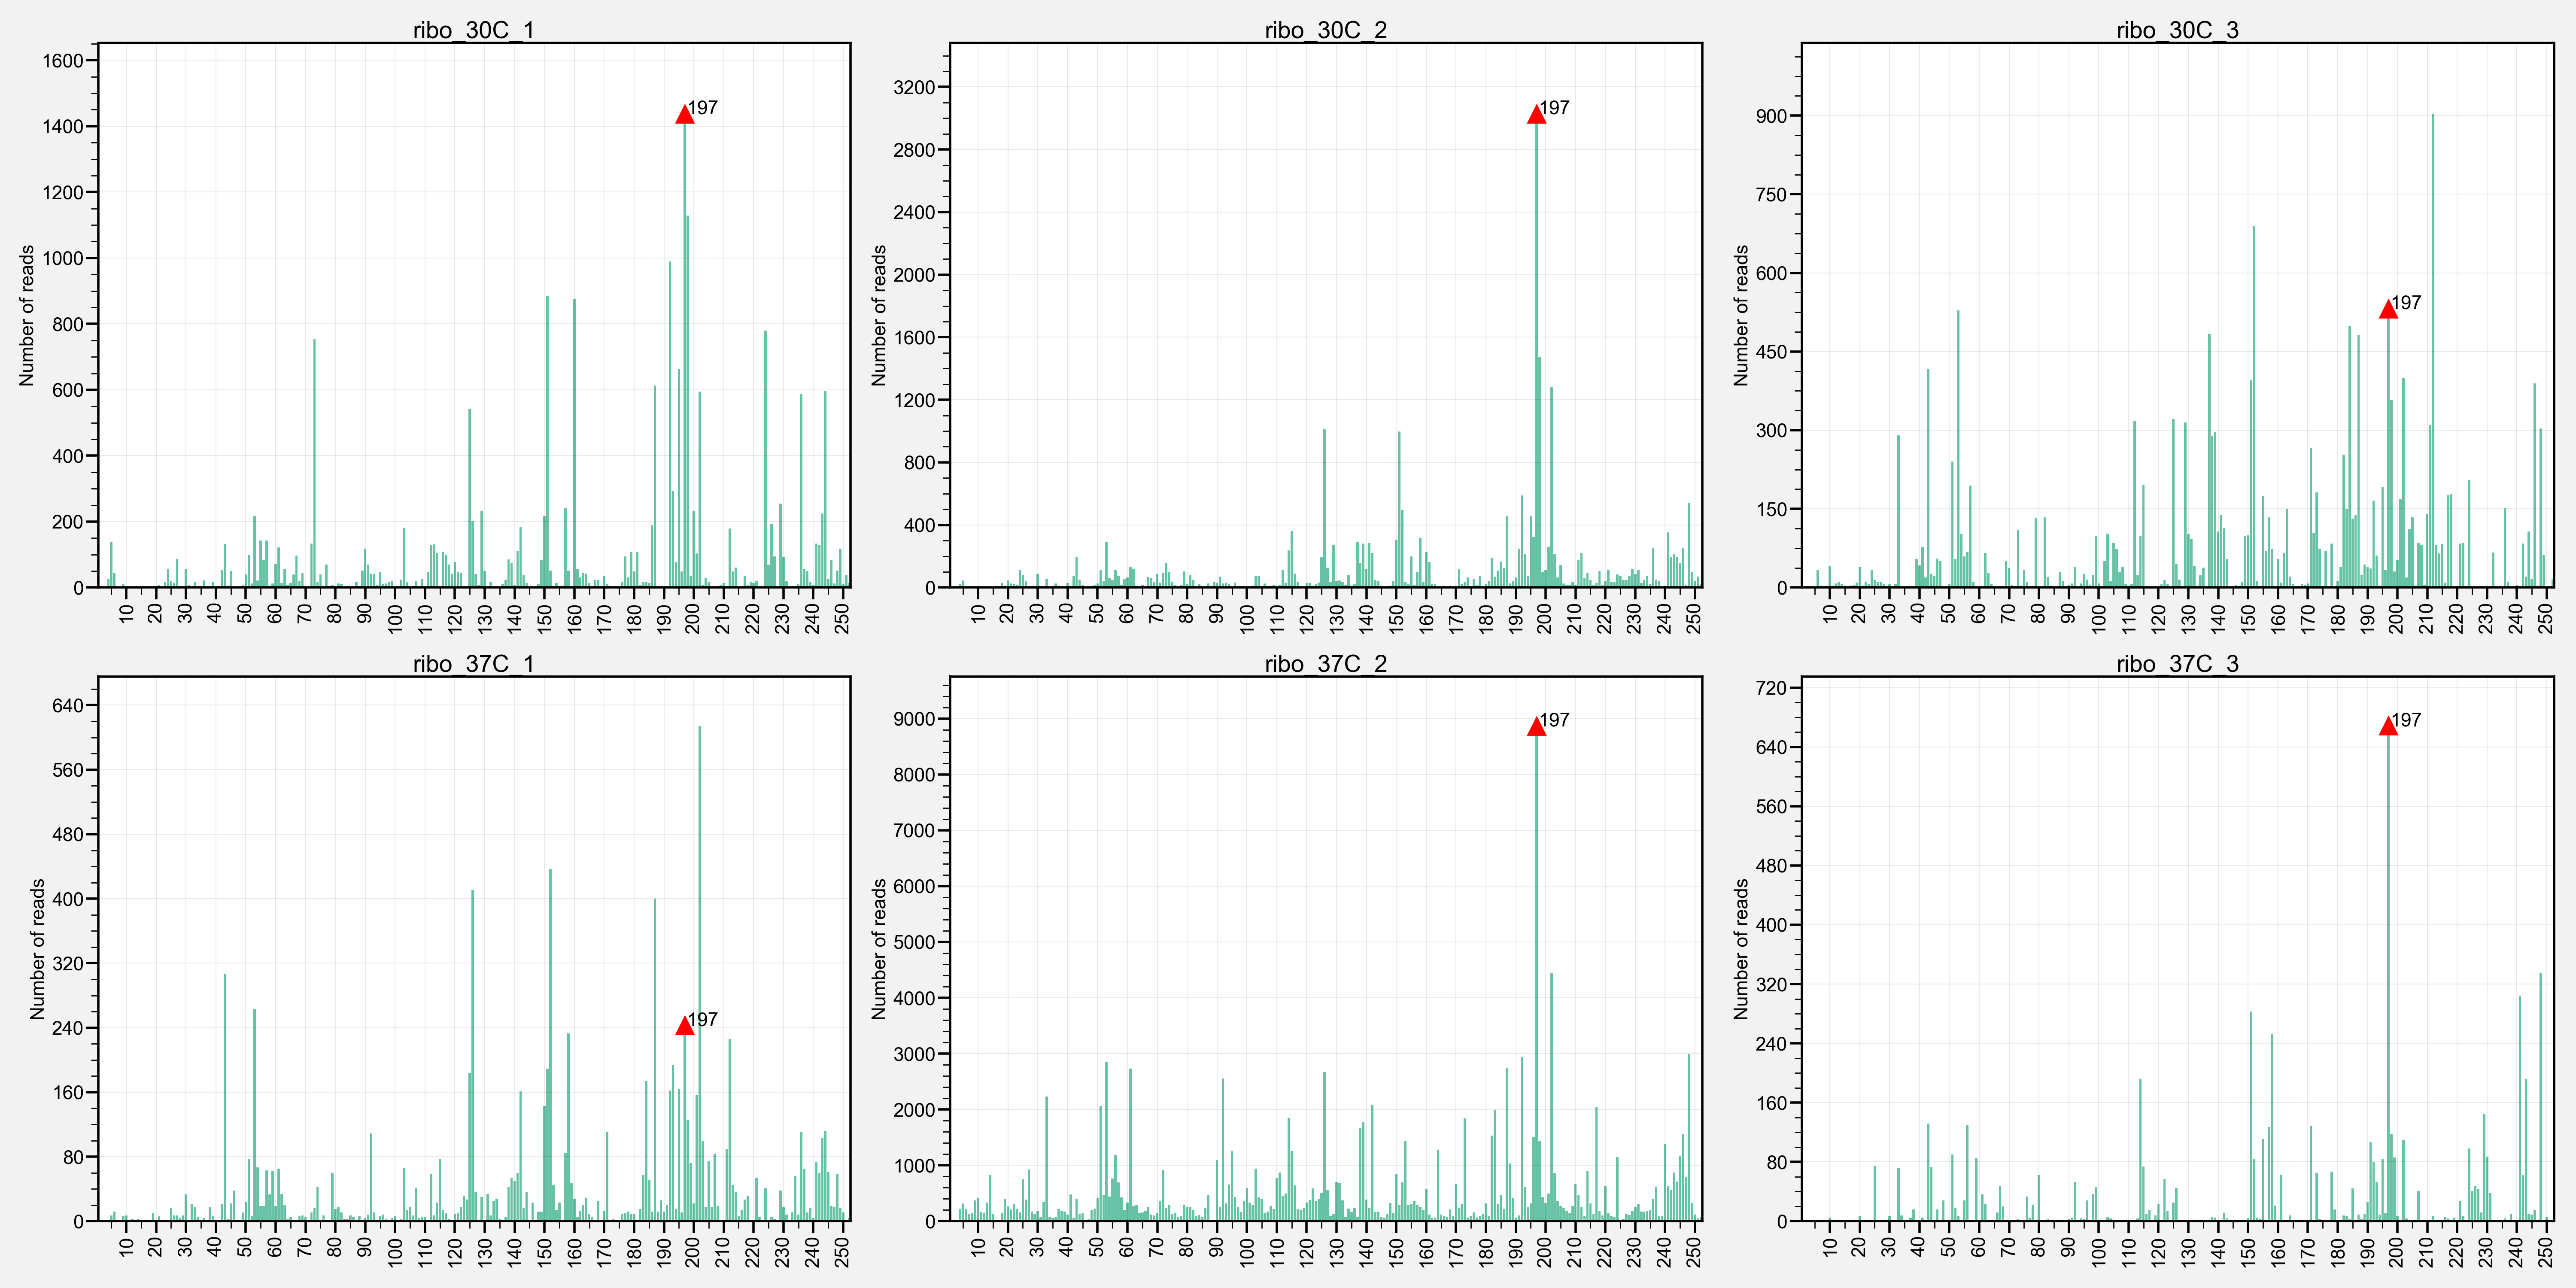

In [46]:
plot_orf_codon('C1_11060C_A-T_2435732_2436489_758', True)	

In [47]:
samplewise_tpm

ribo_30C_1  ribo_30C_2  ribo_30C_3  \
ORF_ID                                                                  
C1_00010W_A-T_4059_4394_336               0.0       0.000         0.0   
C1_00010W_B-T_4059_4394_336               0.0       0.000         0.0   
C1_00020C_A-T_4412_4720_309               0.0       0.000         0.0   
C1_00020C_B-T_4412_4720_309               0.0       0.000         0.0   
C1_00030C_A-T_8600_8908_309               0.0       0.000         0.0   
...                                       ...         ...         ...   
MSTRG.9904.1_624326_624394_69             0.0       0.000         0.0   
MSTRG.9904.1_624376_624444_69             0.0       0.000         0.0   
MSTRG.10192.1_1371227_1371340_114         0.0       1.450         0.0   
MSTRG.10192.1_1371184_1371243_60          0.0       0.000         0.0   
MSTRG.10192.1_1371219_1371284_66          0.0       2.505         0.0   

                                   ribo_37C_1  ribo_37C_2  ribo_37C_3  \
ORF_ID                                                                  
C1_00010W_A-T_4059_4394_336             0.000       0.033       0.000   
C1_00010W_B-T_4059_4394_336             0.000       0.000       0.000   
C1_00020C_A-T_4412_4720_309             0.000       2.662       0.617   
C1_00020C_B-T_4412_4720_309             0.000       0.072       0.000   
C1_00030C_A-T_8600_8908_309             0.000       0.000       0.000   
...                                       ...         ...         ...   
MSTRG.9904.1_624326_624394_69           0.000       0.161       0.000   
MSTRG.9904.1_624376_624444_69           2.073      40.279       5.523   
MSTRG.10192.1_1371227_1371340_114       0.000       2.048       0.000   
MSTRG.10192.1_1371184_1371243_60        0.000       2.594       0.000   
MSTRG.10192.1_1371219_1371284_66        0.000       4.043       0.000   

                                   ribo_30C_avg  ribo_37C_avg       avg  
ORF_ID                                                                   
C1_00010W_A-T_4059_4394_336            0.000000      0.011000  0.005500  
C1_00010W_B-T_4059_4394_336            0.000000      0.000000  0.000000  
C1_00020C_A-T_4412_4720_309            0.000000      1.093000  0.546500  
C1_00020C_B-T_4412_4720_309            0.000000      0.024000  0.012000  
C1_00030C_A-T_8600_8908_309            0.000000      0.000000  0.000000  
...                                         ...           ...       ...  
MSTRG.9904.1_624326_624394_69          0.000000      0.053667  0.026833  
MSTRG.9904.1_624376_624444_69          0.000000     15.958333  7.979167  
MSTRG.10192.1_1371227_1371340_114      0.483333      0.682667  0.583000  
MSTRG.10192.1_1371184_1371243_60       0.000000      0.864667  0.432333  
MSTRG.10192.1_1371219_1371284_66       0.835000      1.347667  1.091333  

[41522 rows x 9 columns]

# Merge with features

In [48]:
peaks_30C_37C_df_combined.head()

peak_30C peak_37C
ORF_ID                                          
C1_00140W_A-T_22270_25323_3054       []    [520]
C1_00400W_A-T_63202_64347_1146    [291]       []
C1_00450C_A-T_72744_73091_348      [80]       []
C1_00590W_A-T_95153_95311_159      [49]       []
C1_00590W_A-T_95214_96491_1278    [250]       []

In [49]:
samplewise_tpm.head()

ribo_30C_1  ribo_30C_2  ribo_30C_3  ribo_37C_1  \
ORF_ID                                                                        
C1_00010W_A-T_4059_4394_336         0.0         0.0         0.0         0.0   
C1_00010W_B-T_4059_4394_336         0.0         0.0         0.0         0.0   
C1_00020C_A-T_4412_4720_309         0.0         0.0         0.0         0.0   
C1_00020C_B-T_4412_4720_309         0.0         0.0         0.0         0.0   
C1_00030C_A-T_8600_8908_309         0.0         0.0         0.0         0.0   

                             ribo_37C_2  ribo_37C_3  ribo_30C_avg  \
ORF_ID                                                              
C1_00010W_A-T_4059_4394_336       0.033       0.000           0.0   
C1_00010W_B-T_4059_4394_336       0.000       0.000           0.0   
C1_00020C_A-T_4412_4720_309       2.662       0.617           0.0   
C1_00020C_B-T_4412_4720_309       0.072       0.000           0.0   
C1_00030C_A-T_8600_8908_309       0.000       0.000           0.0   

                             ribo_37C_avg     avg  
ORF_ID                                             
C1_00010W_A-T_4059_4394_336         0.011  0.0055  
C1_00010W_B-T_4059_4394_336         0.000  0.0000  
C1_00020C_A-T_4412_4720_309         1.093  0.5465  
C1_00020C_B-T_4412_4720_309         0.024  0.0120  
C1_00030C_A-T_8600_8908_309         0.000  0.0000

In [59]:
peaks_30C_37C_df_combined_tpm = peaks_30C_37C_df_combined.join(samplewise_tpm).sort_values(by=['avg', 'ribo_30C_avg', 'ribo_37C_avg'], ascending=[False, False, False])
peaks_30C_37C_df_consistent_df_tpm = peaks_30C_37C_df_consistent_df.set_index('ORF_ID').join(samplewise_tpm).sort_values(by=['avg', 'ribo_30C_avg', 'ribo_37C_avg'], ascending=[False, False, False])
peaks_30C_37C_df_differential_df_tpm = peaks_30C_37C_df_differential_df.set_index('ORF_ID').join(samplewise_tpm).sort_values(by=['avg', 'ribo_30C_avg', 'ribo_37C_avg'], ascending=[False, False, False])

peaks_30C_37C_df_combined_tpm

peak_30C peak_37C  ribo_30C_1  ribo_30C_2  \
ORF_ID                                                                         
CR_01770C_A-T_403929_403988_60           []      [4]   11220.557   74019.477   
MSTRG.9377.6_1424136_1424225_90         [8]       []   14183.280   41851.931   
CR_01770C_A-T_403879_404004_126          []     [10]    5351.972   35403.503   
C2_06810C_A-T_1395420_1395641_222        []     [48]    8839.697    5999.085   
C4_06570C_A-T_1468071_1469771_1701       []    [548]    1508.087    1557.540   
...                                     ...      ...         ...         ...   
C2_07350W_B-T_1500509_1503142_2634       []    [674]       2.540       0.377   
C5_00790C_B-T_186140_188233_2094         []    [328]       1.531       2.092   
C4_06820C_A-T_1521215_1521427_213        []      [5]       0.000       0.000   
C1_00890W_B-T_176334_178481_2148         []    [220]       1.492       0.577   
C4_06820C_A-T_1521358_1521609_252        []     [66]       0.000       0.000   

                                    ribo_30C_3  ribo_37C_1  ribo_37C_2  \
ORF_ID                                                                   
CR_01770C_A-T_403929_403988_60       85509.514  173591.397   18599.030   
MSTRG.9377.6_1424136_1424225_90       4164.312    1995.769    3986.415   
CR_01770C_A-T_403879_404004_126      41062.226   82869.139   13718.671   
C2_06810C_A-T_1395420_1395641_222     6296.698    3657.035    2408.072   
C4_06570C_A-T_1468071_1469771_1701    3040.254    5780.302    3059.031   
...                                        ...         ...         ...   
C2_07350W_B-T_1500509_1503142_2634       0.082       1.140       3.140   
C5_00790C_B-T_186140_188233_2094         1.953       0.683       0.637   
C4_06820C_A-T_1521215_1521427_213        0.000       1.343       4.280   
C1_00890W_B-T_176334_178481_2148         0.000       0.200       0.373   
C4_06820C_A-T_1521358_1521609_252        0.000       1.135       4.411   

                                    ribo_37C_3  ribo_30C_avg  ribo_37C_avg  \
ORF_ID                                                                       
CR_01770C_A-T_403929_403988_60       11761.950  56916.516000  67984.125667   
MSTRG.9377.6_1424136_1424225_90     122844.211  20066.507667  42942.131667   
CR_01770C_A-T_403879_404004_126       6198.220  27272.567000  34262.010000   
C2_06810C_A-T_1395420_1395641_222     2183.352   7045.160000   2749.486333   
C4_06570C_A-T_1468071_1469771_1701    9420.008   2035.293667   6086.447000   
...                                        ...           ...           ...   
C2_07350W_B-T_1500509_1503142_2634       0.217      0.999667      1.499000   
C5_00790C_B-T_186140_188233_2094         0.364      1.858667      0.561333   
C4_06820C_A-T_1521215_1521427_213        0.894      0.000000      2.172333   
C1_00890W_B-T_176334_178481_2148         3.725      0.689667      1.432667   
C4_06820C_A-T_1521358_1521609_252        0.756      0.000000      2.100667   

                                             avg  
ORF_ID                                            
CR_01770C_A-T_403929_403988_60      62450.320833  
MSTRG.9377.6_1424136_1424225_90     31504.319667  
CR_01770C_A-T_403879_404004_126     30767.288500  
C2_06810C_A-T_1395420_1395641_222    4897.323167  
C4_06570C_A-T_1468071_1469771_1701   4060.870333  
...                                          ...  
C2_07350W_B-T_1500509_1503142_2634      1.249333  
C5_00790C_B-T_186140_188233_2094        1.210000  
C4_06820C_A-T_1521215_1521427_213       1.086167  
C1_00890W_B-T_176334_178481_2148        1.061167  
C4_06820C_A-T_1521358_1521609_252       1.050333  

[402 rows x 11 columns]

In [60]:
peaks_30C_37C_df_differential_df_tpm

peak_30C peak_37C  ribo_30C_1  ribo_30C_2  \
ORF_ID                                                                         
CR_01770C_A-T_403929_403988_60           []      [4]   11220.557   74019.477   
MSTRG.9377.6_1424136_1424225_90         [8]       []   14183.280   41851.931   
CR_01770C_A-T_403879_404004_126          []     [10]    5351.972   35403.503   
C2_06810C_A-T_1395420_1395641_222        []     [48]    8839.697    5999.085   
C4_06570C_A-T_1468071_1469771_1701       []    [548]    1508.087    1557.540   
...                                     ...      ...         ...         ...   
C2_07350W_B-T_1500509_1503142_2634       []    [674]       2.540       0.377   
C5_00790C_B-T_186140_188233_2094         []    [328]       1.531       2.092   
C4_06820C_A-T_1521215_1521427_213        []      [5]       0.000       0.000   
C1_00890W_B-T_176334_178481_2148         []    [220]       1.492       0.577   
C4_06820C_A-T_1521358_1521609_252        []     [66]       0.000       0.000   

                                    ribo_30C_3  ribo_37C_1  ribo_37C_2  \
ORF_ID                                                                   
CR_01770C_A-T_403929_403988_60       85509.514  173591.397   18599.030   
MSTRG.9377.6_1424136_1424225_90       4164.312    1995.769    3986.415   
CR_01770C_A-T_403879_404004_126      41062.226   82869.139   13718.671   
C2_06810C_A-T_1395420_1395641_222     6296.698    3657.035    2408.072   
C4_06570C_A-T_1468071_1469771_1701    3040.254    5780.302    3059.031   
...                                        ...         ...         ...   
C2_07350W_B-T_1500509_1503142_2634       0.082       1.140       3.140   
C5_00790C_B-T_186140_188233_2094         1.953       0.683       0.637   
C4_06820C_A-T_1521215_1521427_213        0.000       1.343       4.280   
C1_00890W_B-T_176334_178481_2148         0.000       0.200       0.373   
C4_06820C_A-T_1521358_1521609_252        0.000       1.135       4.411   

                                    ribo_37C_3  ribo_30C_avg  ribo_37C_avg  \
ORF_ID                                                                       
CR_01770C_A-T_403929_403988_60       11761.950  56916.516000  67984.125667   
MSTRG.9377.6_1424136_1424225_90     122844.211  20066.507667  42942.131667   
CR_01770C_A-T_403879_404004_126       6198.220  27272.567000  34262.010000   
C2_06810C_A-T_1395420_1395641_222     2183.352   7045.160000   2749.486333   
C4_06570C_A-T_1468071_1469771_1701    9420.008   2035.293667   6086.447000   
...                                        ...           ...           ...   
C2_07350W_B-T_1500509_1503142_2634       0.217      0.999667      1.499000   
C5_00790C_B-T_186140_188233_2094         0.364      1.858667      0.561333   
C4_06820C_A-T_1521215_1521427_213        0.894      0.000000      2.172333   
C1_00890W_B-T_176334_178481_2148         3.725      0.689667      1.432667   
C4_06820C_A-T_1521358_1521609_252        0.756      0.000000      2.100667   

                                             avg  
ORF_ID                                            
CR_01770C_A-T_403929_403988_60      62450.320833  
MSTRG.9377.6_1424136_1424225_90     31504.319667  
CR_01770C_A-T_403879_404004_126     30767.288500  
C2_06810C_A-T_1395420_1395641_222    4897.323167  
C4_06570C_A-T_1468071_1469771_1701   4060.870333  
...                                          ...  
C2_07350W_B-T_1500509_1503142_2634      1.249333  
C5_00790C_B-T_186140_188233_2094        1.210000  
C4_06820C_A-T_1521215_1521427_213       1.086167  
C1_00890W_B-T_176334_178481_2148        1.061167  
C4_06820C_A-T_1521358_1521609_252       1.050333  

[375 rows x 11 columns]

In [61]:
peaks_30C_37C_df_consistent_df_tpm

peak  ribo_30C_1  ribo_30C_2  ribo_30C_3  \
ORF_ID                                                                          
C2_06810C_A-T_1395466_1395984_519   [163]    4268.590    2839.859    2967.971   
C1_11060C_A-T_2435732_2436489_758   [196]    3701.447    2833.187    2537.679   
C4_04480C_A-T_962664_963222_559     [176]    3958.657    1993.568    2109.201   
C5_04590C_A-T_997026_997109_84        [1]     872.821    4058.148    4419.477   
CR_08210C_A-T_1783407_1785737_2331  [559]    1309.963    1638.635    1427.203   
C5_00270W_A-T_45823_46215_393        [82]    1795.346     978.233     683.611   
C1_03620C_A-T_751876_751995_120      [36]     259.025     290.683     574.058   
C3_04910C_A-T_1056614_1056769_156    [23]     403.861     314.209     783.810   
C6_03700W_A-T_791291_795070_3780    [602]     549.394     398.708     326.894   
C5_03350W_A-T_761964_763085_1122    [221]     358.154     396.717     356.292   
C5_00110C_A-T_12557_14674_2118      [224]     319.508     297.072     156.067   
C2_09060C_A-T_1851752_1853470_1719  [559]     316.638     252.111     246.141   
C2_06730W_A-T_1379376_1380326_951   [234]     301.196     277.702     280.238   
CR_09700W_A-T_2063015_2063107_93     [21]     106.413     486.175     379.619   
C1_08360C_A-T_1834131_1834271_141     [3]     213.527     196.974     298.480   
CR_09700W_A-T_2063040_2063186_147    [13]      67.322     307.580     240.167   
CR_09700W_A-T_2062969_2063121_153    [36]      64.682     295.518     230.749   
C2_08290C_A-T_1675756_1675860_105     [3]      27.877      48.808     194.770   
C1_01530C_A-T_306621_308486_1866    [336]     271.750     145.871     188.449   
C7_01900W_A-T_406702_408135_1434    [371]     130.735     130.444      98.479   
CR_00080W_A-T_21385_24459_3075      [604]     125.334     114.539      72.842   
C3_01600W_A-T_351734_352813_1080    [346]      79.243      65.897      84.315   
CR_07400C_A-T_1607446_1607598_153    [46]      29.153      60.508     104.118   
C2_01830W_A-T_336552_338492_1941    [637]      11.490       7.282      10.093   
C1_10160W_B-T_2236271_2237191_921   [273]       3.632      11.039       7.596   
CR_07590W_B-T_1649105_1649704_600   [104]      22.302       9.092       0.897   
C1_06070W_B-T_1272832_1273371_540    [79]       5.937       7.501       9.966   

                                    ribo_37C_1  ribo_37C_2  ribo_37C_3  \
ORF_ID                                                                   
C2_06810C_A-T_1395466_1395984_519     1826.877    1568.732    1164.095   
C1_11060C_A-T_2435732_2436489_758     1760.066    1927.412    1534.281   
C4_04480C_A-T_962664_963222_559       1984.985    1831.334    1951.637   
C5_04590C_A-T_997026_997109_84         357.522    3792.601     322.084   
CR_08210C_A-T_1783407_1785737_2331     958.608    1045.494    1642.582   
C5_00270W_A-T_45823_46215_393          727.781     620.513     983.669   
C1_03620C_A-T_751876_751995_120        869.971     662.663     125.431   
C3_04910C_A-T_1056614_1056769_156      402.442     364.151     144.118   
C6_03700W_A-T_791291_795070_3780       154.283     218.627     322.084   
C5_03350W_A-T_761964_763085_1122       242.937     214.343     375.113   
C5_00110C_A-T_12557_14674_2118         252.595     246.588     465.616   
C2_09060C_A-T_1851752_1853470_1719     227.616     320.180     333.840   
C2_06730W_A-T_1379376_1380326_951      291.131     275.574     245.423   
CR_09700W_A-T_2063015_2063107_93        73.811     153.605     376.959   
C1_08360C_A-T_1834131_1834271_141      320.502     153.824     171.611   
CR_09700W_A-T_2063040_2063186_147       46.697      97.557     238.484   
CR_09700W_A-T_2062969_2063121_153       44.866      93.876     229.132   
C2_08290C_A-T_1675756_1675860_105       77.633     131.074     457.268   
C1_01530C_A-T_306621_308486_1866        70.125     121.113      90.363   
C7_01900W_A-T_406702_408135_1434       103.218     120.573     139.110   
CR_00080W_A-T_21385_24459_3075          78.783     148.494 

In [62]:
peaks_30C_37C_df_combined_tpm.to_csv('../data/pausing_sites/peaks_30C_37C_df_combined_tpm.tsv', sep="\t", index=True)
peaks_30C_37C_df_differential_df_tpm.to_csv('../data/pausing_sites/peaks_30C_37C_df_differential_df_tpm.tsv', sep="\t", index=True)
peaks_30C_37C_df_consistent_df_tpm.to_csv('../data/pausing_sites/peaks_30C_37C_df_consistent_df_tpm.tsv', sep="\t", index=True)

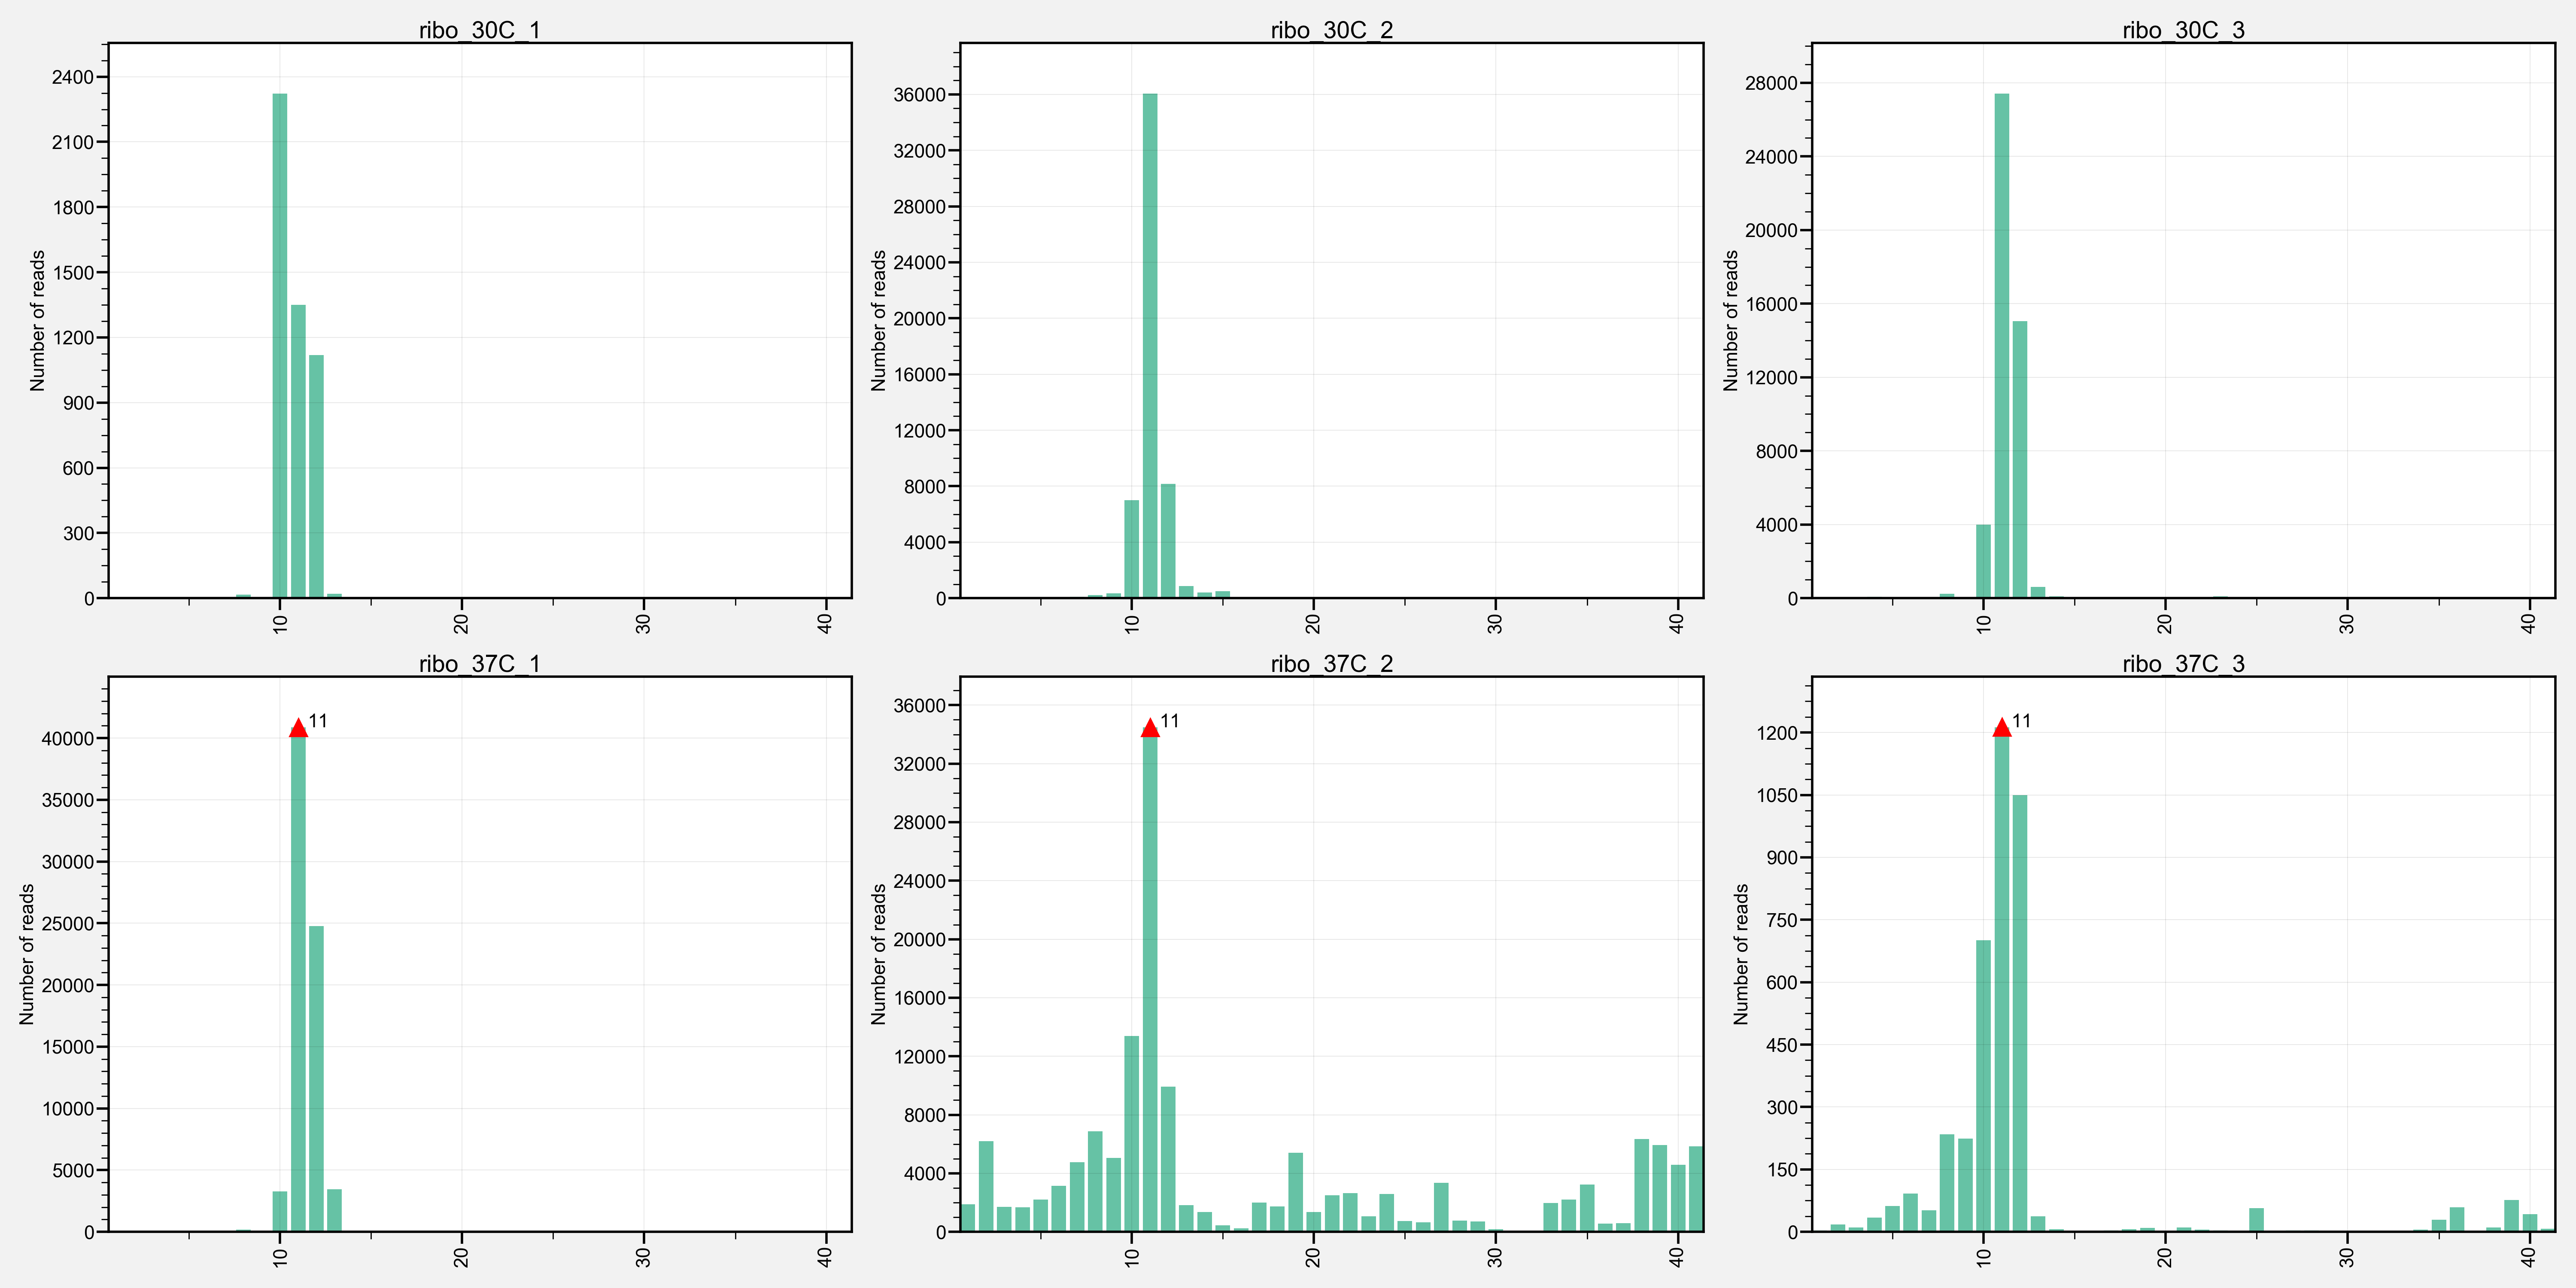

In [55]:
plot_orf_codon('CR_01770C_A-T_403879_404004_126', True)

In [ ]:
peaks_30C_37C_df_combined_profiles = pd.read_csv('../data/pausing_sites/peaks_30C_37C_df_combined_profiles.tsv', sep='\t')
peaks_30C_37C_df_differential_df_profiles = pd.read_csv('../data/pausing_sites/peaks_30C_37C_df_differential_profiles.tsv', sep='\t')
peaks_30C_37C_df_consistent_df_profiles = pd.read_csv('../data/pausing_sites/peaks_30C_37C_df_consistent_df_profiles.tsv', sep='\t')





In [69]:
def get_orf(desc):
    desc = str(desc)
    all_matches = [x for x in re.findall('orf19.\d+|', desc) if x!='']
    matches = (',').join(all_matches)
    return matches

def get_gene_id(name):
    return name.split('___')[0]

In [70]:
features = pd.read_table('/home/cmb-panasas2/skchoudh/genomes/C_albicans_SC5314/Assembly22/annotation/C_albicans_SC5314_version_A22-s07-m01-r27_chromosomal_feature.tab', 
                         skiprows=8, sep='\t',
                         names=['feature_name', 'gene_name_feature', 'alias', 'feature_type',
                              'chromosome', 'start_cooridnate', 'stop_coordinate',
                              'strand', 'primary_cgdid', 'secondary_cgdid', 'description', 'date_created', 
                               'version_date',
                              'blank1', 'blank2', 'data_gene_reserv', 'gene_name_standard', 'orthologs'])
#features = features.reset_index()

features = features.rename(columns={'feature_name': 'gene_id'})
features = features.set_index('gene_id')


features['orf19'] = features.alias.apply(lambda x: get_orf(x))
features_A = features.loc[features.index.str.contains('_A')]
features_A.index = features_A.index.str.rstrip('_A')
features_A.head()
#features.head()

gene_name_feature  \
gene_id                       
C1_00010W               NaN   
C1_00020C               NaN   
C1_00030C               NaN   
C1_00040W              CTA2   
C1_00050C               NaN   

                                                       alias  \
gene_id                                                        
C1_00010W  orf19.6115|C1_00010W_B|C1_00010W|orf19.13534|I...   
C1_00020C  CAWG_03102|orf19.6114|C1_00020C_B|C1_00020C|or...   
C1_00030C  orf19.6113|C1_00030C_B|C1_00030C|orf19.13532|I...   
C1_00040W  CAWG_01362|orf19.6112|C1_00040W_B|C1_00040W|or...   
C1_00050C  CAWG_01361|orf19.6110|C1_00050C_B|C1_00050C|or...   

                  feature_type                   chromosome  start_cooridnate  \
gene_id                                                                         
C1_00010W          ORF|Dubious  Ca22chr1A_C_albicans_SC5314            4059.0   
C1_00020C  ORF|Uncharacterized  Ca22chr1A_C_albicans_SC5314            4720.0   
C1_00030C  ORF|Uncharacterized  Ca22chr1A_C_albicans_SC5314            8908.0   
C1_00040W         ORF|Verified  Ca22chr1A_C_albicans_SC5314           10718.0   
C1_00050C          ORF|Dubious  Ca22chr1A_C_albicans_SC5314           11995.0   

           stop_coordinate strand  primary_cgdid secondary_cgdid  \
gene_id                                                            
C1_00010W           4397.0      W  CAL0000182519             NaN   
C1_00020C           4409.0      C  CAL0000184345             NaN   
C1_00030C           8597.0      C  CAL0000177679             NaN   
C1_00040W          11485.0      W  CAL0000191731             NaN   
C1_00050C          11648.0      C  CAL0000182943             NaN   

                                                 description date_created  \
gene_id                                                                     
C1_00010W                         Dubious open reading frame   2014-06-24   
C1_00020C  Protein of unknown function; transcript detect...   2014-06-24   
C1_00030C  Protein of unknown function; transcript detect...   2014-06-24   
C1_00040W  Putative transcription factor; Med2 mediator d...   2014-06-24   
C1_00050C     Ortholog of Candida albicans WO-1 : CAWG_01361   2014-06-24   

          version_date  blank1  blank2 data_gene_reserv gene_name_standard  \
gene_id                                                                      
C1_00010W   2014-06-24     NaN     NaN              NaN                  N   
C1_00020C   2014-06-24     NaN     NaN              NaN                  N   
C1_00030C   2014-06-24     NaN     NaN              NaN                  N   
C1_00040W   2014-06-24     NaN     NaN              NaN                  N   
C1_00050C   2014-06-24     NaN     NaN              NaN                  N   

          orthologs                   orf19  
gene_id                                      
C1_00010W       NaN  orf19.6115,orf19.13534  
C1_00020C       NaN  orf19.6114,orf19.13533  
C1_00030C       NaN  orf19.6113,orf19.13532  
C1_00040W       NaN  orf19.6112,orf19.13531  
C1_00050C       NaN  orf19.6110,orf19.13529

# Merge with features

In [99]:
TE_results = pd.read_excel('../data/merged_TE/Oct_2019_Kadosh_C_albicans_30C_37C_merged_TE.xls', index_col=0)
TE_results.index.name = 'gene_id'
TE_results

log2FC_TE_superuorf_37C_vs_30C  pval_TE_superuorf_37C_vs_30C  \
gene_id                                                                   
C2_08890W                             NaN                           NaN   
C5_01790C                             NaN                           NaN   
CR_04440C                             NaN                           NaN   
C2_01460C                             NaN                           NaN   
C3_07980C                             NaN                           NaN   
...                                   ...                           ...   
C2_10750C                             NaN                           NaN   
C4_04700W                             NaN                           NaN   
C3_04130W                       -0.632751                      0.742212   
C1_10450W                        1.385265                      0.328219   
CR_02630C                             NaN                           NaN   

           padj_TE_superuorf_37C_vs_30C  log2FC_TE_annotated_37C_vs_30C  \
gene_id                                                                   
C2_08890W                           NaN                       -9.983122   
C5_01790C                           NaN                        8.359031   
CR_04440C                           NaN                       -7.701476   
C2_01460C                           NaN                       -7.401327   
C3_07980C                           NaN                       -6.766679   
...                                 ...                             ...   
C2_10750C                           NaN                        0.000352   
C4_04700W                           NaN                       -0.000291   
C3_04130W                           NaN                        0.000197   
C1_10450W                      0.638473                       -0.000185   
CR_02630C                           NaN                        0.000062   

           pval_TE_annotated_37C_vs_30C  padj_TE_annotated_37C_vs_30C  \
gene_id                                                                 
C2_08890W                           NaN                           NaN   
C5_01790C                      0.000005                      0.030556   
CR_04440C                           NaN                           NaN   
C2_01460C                      0.000712                      0.398253   
C3_07980C                      0.000509                      0.388773   
...                                 ...                           ...   
C2_10750C                      0.999477                      0.999949   
C4_04700W                      0.999474                      0.999949   
C3_04130W                      0.999791                      0.999951   
C1_10450W                      0.999628                      0.999949   
CR_02630C                      0.999967                      0.999967   

           log2FC_ribo_vs_rna_superuorf_37C  pval_ribo_vs_rna_superuorf_37C  \
gene_id                                                                       
C2_08890W                               NaN                             NaN   
C5_01790C                               NaN                             NaN   
CR_04440C                               NaN                             NaN   
C2_01460C                               NaN                             NaN   
C3_07980C                               NaN                             NaN   
...                                     ...                             ...   
C2_10750C                               NaN                             NaN   
C4_04700W                               NaN                             NaN   
C3_04130W                         -1.385570                        0.235985   
C1_10450W                         -2.480094                        0.021149   
CR_02630C                               NaN                             NaN   

           padj_ribo_vs_rna_superuorf_37C  log2FC_ribo_vs_rna_annotated_37C  \
ge

In [108]:
#peaks_30C_37C_df_consistent_df_tpm.index.str.split('-T').str.get(0).str.rstrip('_A').str.rstrip('_B')
ribotricer_annotation = pd.read_csv('/home/qcb-panasas/skchoudh/github_projects/C_albicans_project/notebooks/July_07_GTF_analysis/C_albicans_SC5314_version_A22-s07-m01-r27_features.UTR5_CDS_UTR3_cleaned_ribotricer_longest_candidate_orfs.tsv', sep='\t').set_index('ORF_ID')
ribotricer_annotation = ribotricer_annotation.rename(columns={"gene_id": "gene_id_allele"})
#ribotricer_annotation
def combine_tpm_features_df(df, features_df):
    df = df.copy().reset_index()
    df['gene_id'] = df.ORF_ID.str.split('-T').str.get(0).str.rstrip('_A').str.rstrip('_B')
    df = df.set_index('gene_id')
    cols = ['ribo_30C_1', 'ribo_30C_2', 'ribo_30C_3']+ ['ribo_37C_1', 'ribo_37C_2', 'ribo_37C_3']
    df = df.drop(columns=cols)
    df = df.rename(columns={'ribo_30C_avg': 'ribo_30C_tpm', 'ribo_37C_avg': 'ribo_37C_tpm', 'avg': 'ribo_30C_37C_avg_tpm'})

    df_combined = df.join(features_df[['description']])# 'orf19']])
    df_combined = df_combined.fillna("N/A")
    df_combined = df_combined.join(TE_results[["log2FC_TE_annotated_37C_vs_30C", "pval_TE_annotated_37C_vs_30C", "log2FC_TE_superuorf_37C_vs_30C",	"pval_TE_superuorf_37C_vs_30C"]])
    
    df_combined = df_combined.reset_index().set_index('ORF_ID')
    df_combined = df_combined.join(ribotricer_annotation[["ORF_type", "gene_id_allele", "start_codon"]])
    return df_combined

In [111]:
peaks_30C_37C_df_combined_tpm_desc = combine_tpm_features_df(peaks_30C_37C_df_combined_tpm, features_A)
peaks_30C_37C_df_combined_tpm_desc.start_codon.value_counts()

ATG    284
ATT     21
ATC     19
AAG     17
ATA     12
TTG      8
GTG      6
CTG      6
AGG      5
GCA      2
TCT      2
ACG      2
TAC      2
GTT      1
CCG      1
TCG      1
TTA      1
TGC      1
TAT      1
GTA      1
GCC      1
ACT      1
CAA      1
CTA      1
Name: start_codon, dtype: int64

In [110]:
peaks_30C_37C_df_combined_tpm_desc = combine_tpm_features_df(peaks_30C_37C_df_combined_tpm, features_A)
peaks_30C_37C_df_combined_tpm_desc.to_csv("../data/pausing_sites/peaks_30C_37C_df_combined_tpm_desc.tsv", sep="\t", index=True)

peaks_30C_37C_df_differential_df_tpm_desc = combine_tpm_features_df(peaks_30C_37C_df_differential_df_tpm, features_A)
peaks_30C_37C_df_differential_df_tpm_desc.to_csv('../data/pausing_sites/peaks_30C_37C_df_differential_df_tpm_desc.tsv', sep="\t", index=True)


peaks_30C_37C_df_consistent_df_tpm_desc = combine_tpm_features_df(peaks_30C_37C_df_consistent_df_tpm, features_A)
peaks_30C_37C_df_consistent_df_tpm_desc.to_csv('../data/pausing_sites/peaks_30C_37C_df_consistent_df_tpm_desc.tsv', sep="\t", index=True)


# Analyze codons of these ORFs

In [255]:
orfs_seq = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/C_albicans_project/notebooks/July_07_GTF_analysis/C_albicans_SC5314_version_A22-s07-m01-r27_features.UTR5_CDS_UTR3_cleaned_with_noveltx_ribotricer_longest_candidate_orfs_seq.tsv', sep='\t')

In [269]:
def get_orf_peak_seq(orfs_seq_df, orf_id, peak):
    subset = orfs_seq_df[orfs_seq.ORF_ID==orf_id]
    #print(subset)
    sequence = subset['sequence'].tolist()[0]
    #print(len(sequence))#[peak:peak+3]
    return sequence[peak:peak+3]
    

In [270]:
get_orf_peak_seq(orfs_seq, 'C1_11060C_A-T_2435732_2436489_758', 196)

'CAA'

# Create frames for ribopod visualization

In [94]:
peaks_30C_37C_df_differential_df_tpm_desc

ORF_ID peak_30C  \
gene_id                                                                       
C1_00140W                           C1_00140W_A-T_22270_25323_3054       []   
C1_00400W                           C1_00400W_A-T_63202_64347_1146    [291]   
C1_00450C                            C1_00450C_A-T_72744_73091_348     [80]   
C1_00590W                           C1_00590W_A-T_95214_96491_1278    [250]   
C1_00590W                            C1_00590W_A-T_95153_95311_159     [49]   
...                                                            ...      ...   
MSTRG.2.1_1746_1982_237                    MSTRG.2.1_1746_1982_237       []   
MSTRG.9377.6_1422562_1422756_195  MSTRG.9377.6_1422562_1422756_195       []   
MSTRG.9377.6_1422584_1422715_132  MSTRG.9377.6_1422584_1422715_132       []   
MSTRG.9377.6_1423526_1423639_114  MSTRG.9377.6_1423526_1423639_114       []   
MSTRG.9377.6_1424136_1424225_90    MSTRG.9377.6_1424136_1424225_90      [8]   

                                 peak_37C  ribo_30C_tpm  ribo_37C_tpm  \
gene_id                                                                 
C1_00140W                           [520]     33.051667     57.899667   
C1_00400W                              []    104.064667     79.426667   
C1_00450C                              []     76.641667     47.438000   
C1_00590W                              []    680.428000    626.529333   
C1_00590W                              []    102.748333    303.111667   
...                                   ...           ...           ...   
MSTRG.2.1_1746_1982_237              [32]     28.720667     21.362333   
MSTRG.9377.6_1422562_1422756_195     [45]     24.580667    183.997333   
MSTRG.9377.6_1422584_1422715_132     [38]     30.419667    195.523667   
MSTRG.9377.6_1423526_1423639_114     [34]     15.854667    102.583667   
MSTRG.9377.6_1424136_1424225_90        []  20066.507667  42942.131667   

                                  ribo_30C_37C_avg_tpm gene_name_feature  \
gene_id                                                                    
C1_00140W                                    45.475667              KEL1   
C1_00400W                                    91.745667              SVF1   
C1_00450C                                    62.039833               N/A   
C1_00590W                                   653.478667              TUF1   
C1_00590W                                   202.930000              TUF1   
...                                                ...               ...   
MSTRG.2.1_1746_1982_237                      25.041500               N/A   
MSTRG.9377.6_1422562_1422756_195            104.289000               N/A   
MSTRG.9377.6_1422584_1422715_132            112.971667               N/A   
MSTRG.9377.6_1423526_1423639_114             59.219167               N/A   
MSTRG.9377.6_1424136_1424225_90           31504.319667               N/A   

                                                                        description  \
gene_id                                                                               
C1_00140W                         Kelch repeat domain-containing protein; locali...   
C1_00400W                         Putative survival factor; stationary phase enr...   
C1_00450C                         Mitochondrial protein; component of the mitoch...   
C1_00590W                         Translation elongation factor TU; macrophage/p...   
C1_00590W                         Translation elongation factor TU; macrophage/p...   
...                                                                             ...   
MSTRG.2.1_1746_1982_237                                                         N/A   
MSTRG.9377.6_1422562_1422756_195                                                N/A   
MSTRG.9377.6_1422584_1422715_132                                                N/A   
MSTRG.9377.6_1423526_1423639_114                                                N/A   
MSTRG.9377.6_1424136_1424225_90                  

ORF_ID      ORF_type  transcript_id  \
0           C1_00010W_A-T_4059_4394_336     annotated  C1_00010W_A-T   
1           C1_00010W_B-T_4059_4394_336     annotated  C1_00010W_B-T   
2           C1_00020C_A-T_4412_4720_309     annotated  C1_00020C_A-T   
3           C1_00020C_B-T_4412_4720_309     annotated  C1_00020C_B-T   
4           C1_00030C_A-T_8600_8908_309     annotated  C1_00030C_A-T   
...                                 ...           ...            ...   
41085  CR_10840C_A-T_2283334_2283396_63  overlap_dORF  CR_10840C_A-T   
41086  CR_10840C_B-T_2283892_2283969_78  overlap_uORF  CR_10840C_B-T   
41087  CR_10840C_B-T_2282794_2282856_63  overlap_dORF  CR_10840C_B-T   
41088  CR_10860C_A-T_2285312_2285371_60    super_dORF  CR_10860C_A-T   
41089  CR_10860C_B-T_2284772_2284831_60    super_dORF  CR_10860C_B-T   

      transcript_type      gene_id    gene_name       gene_type  \
0      protein_coding  C1_00010W_A  C1_00010W_A  protein_coding   
1      protein_coding  C1_00010W_B  C1_00010W_B  protein_coding   
2      protein_coding  C1_00020C_A  C1_00020C_A  protein_coding   
3      protein_coding  C1_00020C_B  C1_00020C_B  protein_coding   
4      protein_coding  C1_00030C_A  C1_00030C_A  protein_coding   
...               ...          ...          ...             ...   
41085  protein_coding  CR_10840C_A         XYL2  protein_coding   
41086  protein_coding  CR_10840C_B  CR_10840C_B  protein_coding   
41087  protein_coding  CR_10840C_B  CR_10840C_B  protein_coding   
41088  protein_coding  CR_10860C_A        CTA26  protein_coding   
41089  protein_coding  CR_10860C_B  CR_10860C_B  protein_coding   

                             chrom strand start_codon       coordinate  
0      Ca22chr1A_C_albicans_SC5314      +         ATG        4059-4394  
1      Ca22chr1B_C_albicans_SC5314      +         ATG        4059-4394  
2      Ca22chr1A_C_albicans_SC5314      -         ATG        4412-4720  
3      Ca22chr1B_C_albicans_SC5314      -         ATG        4412-4720  
4      Ca22chr1A_C_albicans_SC5314      -         ATG        8600-8908  
...                            ...    ...         ...              ...  
41085  Ca22chrRA_C_albicans_SC5314      -         GTG  2283334-2283396  
41086  Ca22chrRB_C_albicans_SC5314      -         ATA  2283892-2283969  
41087  Ca22chrRB_C_albicans_SC5314      -         GTG  2282794-2282856  
41088  Ca22chrRA_C_albicans_SC5314      -         AGG  2285312-2285371  
41089  Ca22chrRB_C_albicans_SC5314      -         AGG  2284772-2284831  

[41090 rows x 11 columns]